In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [2]:
ticker         = params.ticker
features_cols  = params.features_cols
label_col      = params.label_col
look_back      = params.look_back_tick

save_path = params.save_path
in_path   = save_path / f"{ticker}_ready.csv"
out_path  = save_path / f"{ticker}_final.csv"

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

df_raw = pd.read_csv(in_path, index_col=0, parse_dates=True)
df  = models.feature_engineering(df_raw)
df.to_csv(out_path)
df

Using device: cuda


open        high         low       close  \
2014-04-03 12:06:00   28.644845   28.644845   28.644845   28.644845   
2014-04-03 12:07:00   28.639690   28.639690   28.639690   28.639690   
2014-04-03 12:08:00   28.634534   28.634534   28.634534   28.634534   
2014-04-03 12:09:00   28.629379   28.629379   28.629379   28.629379   
2014-04-03 12:10:00   28.624224   28.624224   28.624224   28.624224   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  173.375000  173.677100  173.215000  173.565000   
2025-06-18 20:57:00  173.565000  173.590000  173.240000  173.380000   
2025-06-18 20:58:00  173.390000  173.410000  173.200000  173.310000   
2025-06-18 20:59:00  173.315000  173.400000  173.230000  173.280000   
2025-06-18 21:00:00  173.300000  174.050000  173.170000  173.609700   

                        volume       r_1       r_5      r_15    vol_15  \
2014-04-03 12:06:00     4580.0 -0.000180 -0.000180 -0.000180  0.000046   
2014-04-03 12:07:00     4540.0 -0.000180 -0.000360 -0.000360  0.000063   
2014-04-03 12:08:00     4500.0 -0.000180 -0.000540 -0.000540  0.000075   
2014-04-03 12:09:00     4460.0 -0.000180 -0.000720 -0.000720  0.000082   
2014-04-03 12:10:00     4420.0 -0.000180 -0.000900 -0.000900  0.000088   
...                        ...       ...       ...       ...       ...   
2025-06-18 20:56:00   621199.0  0.001124 -0.004226 -0.009661  0.001493   
2025-06-18 20:57:00   624198.0 -0.001066 -0.005063 -0.010671  0.001487   
2025-06-18 20:58:00   454542.0 -0.000404 -0.005811 -0.011816  0.001436   
2025-06-18 20:59:00  1094746.0 -0.000173 -0.004434 -0.011932  0.001432   
2025-06-18 21:00:00  7649838.0  0.001901  0.001382 -0.009290  0.001592   

                     volume_spike  vwap_dev     rsi_14         bid  \
2014-04-03 12:06:00      0.568641 -0.000175   0.000000   28.636251   
2014-04-03 12:07:00      0.570338 -0.000347   0.000000   28.631098   
2014-04-03 12:08:00      0.574408 -0.000514   0.000000   28.625944   
2014-04-03 12:09:00      0.581017 -0.000678   0.000000   28.620791   
2014-04-03 12:10:00      0.590413 -0.000839   0.000000   28.615637   
...                           ...       ...        ...         ...   
2025-06-18 20:56:00      2.462713  1.244200  17.019768  173.512900   
2025-06-18 20:57:00      2.154838  1.241791  11.648165  173.328000   
2025-06-18 20:58:00      1.439161  1.240874  11.384870  173.258000   
2025-06-18 20:59:00      2.836382  1.240456  11.830567  173.228000   
2025-06-18 21:00:00      8.568493  1.244514  22.962317  173.557600   

                            ask  signal_smooth  
2014-04-03 12:06:00   28.653438       0.348119  
2014-04-03 12:07:00   28.648282       0.350522  
2014-04-03 12:08:00   28.643125       0.352920  
2014-04-03 12:09:00   28.637968       0.355314  
2014-04-03 12:10:00   28.632811       0.357703  
...                         ...            ...  
2025-06-18 20:56:00  173.617100       0.002995  
2025-06-18 20:57:00  173.432000       0.002906  
2025-06-18 20:58:00  173.362000       0.005611  
2025-06-18 20:59:00  173.332000       0.006684  
2025-06-18 21:00:00  173.661800       0.003506  

[1498045 rows x 15 columns]

In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# Build LSTM input tensors (disk-backed memmaps)
#    Returns five tensors on `device`:
#      X        : (N, look_back, F)
#      y        : (N,)
#      raw_close: (N,)
#      raw_bid  : (N,)
#      raw_ask  : (N,)
# ──────────────────────────────────────────────────────────────────────────────
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df             = df,
    look_back      = look_back,
    features_cols  = features_cols,
    label_col      = label_col,
    regular_start  = params.regular_start_pred
)

print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)

Shapes:
  X         = torch.Size([990445, 180, 12]) (samples, features, look_back)
  y         = torch.Size([990445]) (samples,)
  raw_close = torch.Size([990445])
  raw_bid   = torch.Size([990445])
  raw_ask   = torch.Size([990445])


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
#    (We use the helper `chronological_split` that returns)
#      (X_tr, y_tr),
#      (X_val, y_val),
#      (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te)
# ──────────────────────────────────────────────────────────────────────────────
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back       = look_back,
    regular_start   = params.regular_start_pred,
    train_prop      = params.train_prop,
    val_prop        = params.val_prop,
    train_batch     = params.hparams['TRAIN_BATCH']
)

print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([677297, 180, 12])
  y_tr        = torch.Size([677297])
  raw_close_te= torch.Size([158668])
  raw_bid_te  = torch.Size([158668])
  raw_ask_te  = torch.Size([158668])


In [5]:
# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"\nBaseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=677297, val=154480, te=158668
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready

Baseline (zero‐forecast) RMSE on validation = 0.464351


In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────
def objective_train(trial):
    # Sample only the knobs you care about
    hp = {
        # Architecture
        "DROPOUT_SHORT"        : trial.suggest_float("DROPOUT_SHORT",     0.15, 0.35),
        "DROPOUT_LONG"         : trial.suggest_float("DROPOUT_LONG",      0.2, 0.45),
        "ATT_HEADS"            : trial.suggest_categorical("ATT_HEADS",   [2 ,4, 8]),
        "ATT_DROPOUT"          : trial.suggest_float("ATT_DROPOUT",       0.1, 0.4),

        # Optimizer & scheduler
        "INITIAL_LR"           : trial.suggest_float("INITIAL_LR",       5e-5, 5e-2), 
        "ETA_MIN"              : trial.suggest_float("ETA_MIN",          5e-7, 5e-4),
        "WEIGHT_DECAY"         : trial.suggest_float("WEIGHT_DECAY",     5e-6, 5e-4),
        "CLIPNORM"             : trial.suggest_float("CLIPNORM",         0.3, 1.0),
        "LR_EPOCHS_WARMUP"     : trial.suggest_int  ("LR_EPOCHS_WARMUP", 0, 12),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    # Build model
    model = models.DualMemoryLSTM(
        n_feats       = len(features_cols),
        short_units   = params.hparams["SHORT_UNITS"],
        long_units    = params.hparams["LONG_UNITS"],
        dropout_short = hp["DROPOUT_SHORT"],
        dropout_long  = hp["DROPOUT_LONG"],
        att_heads     = hp["ATT_HEADS"],
        att_drop      = hp["ATT_DROPOUT"],
    ).to(device)

    # Build optimizer + schedulers + scaler
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )

    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )

    # Run training & return best validation RMSE
    best_rmse = models.custom_stateful_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams["MAX_EPOCHS"],
        early_stop_patience = params.hparams["EARLY_STOP_PATIENCE"],
        baseline_val_rmse   = baseline_val_rmse,
        clipnorm            = clipnorm,
        device              = device,
    )

    del model
    del optimizer
    del plateau_sched
    del cosine_sched
    del scaler

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_rmse



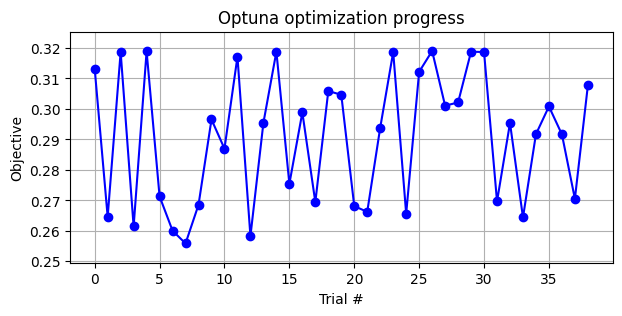

In [7]:
# ----------------------------------------------------------
# create ONE figure
# ----------------------------------------------------------
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-07-24 20:15:29,809] A new study created in RDB with name: no-name-1feafec3-6553-4b69-add8-dfbe57deb50e



▶ Trial 0 starting with:
{'DROPOUT_SHORT': 0.31520671293956426, 'DROPOUT_LONG': 0.3080492806831221, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.16040213654511043, 'INITIAL_LR': 0.04071076402624798, 'ETA_MIN': 0.00044719626316638465, 'WEIGHT_DECAY': 0.0004918875058590105, 'CLIPNORM': 0.8121066992183394, 'LR_EPOCHS_WARMUP': 8}



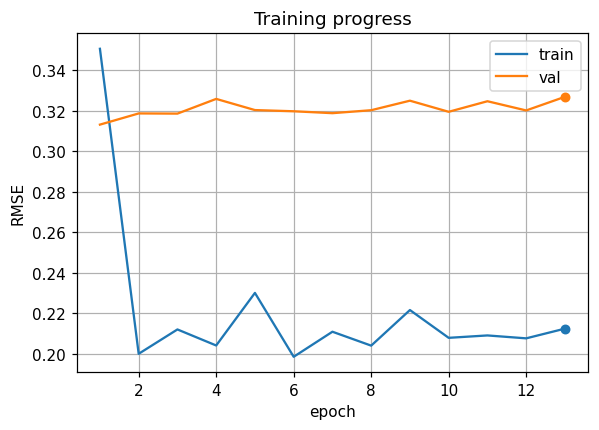

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3507 • val=0.3132 • lr=4.07e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2000 • val=0.3187 • lr=4.06e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2120 • val=0.3186 • lr=4.05e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2041 • val=0.3259 • lr=4.03e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2301 • val=0.3204 • lr=4.00e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1985 • val=0.3198 • lr=3.97e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2109 • val=0.3189 • lr=3.94e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2040 • val=0.3203 • lr=3.90e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2216 • val=0.3250 • lr=3.85e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2079 • val=0.3195 • lr=3.80e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2090 • val=0.3248 • lr=3.75e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2076 • val=0.3202 • lr=3.69e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2124 • val=0.3269 • lr=3.62e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3132.pth


[I 2025-07-24 20:22:09,583] Trial 0 finished with value: 0.31319890753330815 and parameters: {'DROPOUT_SHORT': 0.31520671293956426, 'DROPOUT_LONG': 0.3080492806831221, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.16040213654511043, 'INITIAL_LR': 0.04071076402624798, 'ETA_MIN': 0.00044719626316638465, 'WEIGHT_DECAY': 0.0004918875058590105, 'CLIPNORM': 0.8121066992183394, 'LR_EPOCHS_WARMUP': 8}. Best is trial 0 with value: 0.31319890753330815.



▶ Trial 1 starting with:
{'DROPOUT_SHORT': 0.18799488970779765, 'DROPOUT_LONG': 0.3116735139030016, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.1886740919887237, 'INITIAL_LR': 0.0056980199211651905, 'ETA_MIN': 0.0001481204648279154, 'WEIGHT_DECAY': 4.645356358082672e-05, 'CLIPNORM': 0.6475569820245177, 'LR_EPOCHS_WARMUP': 5}



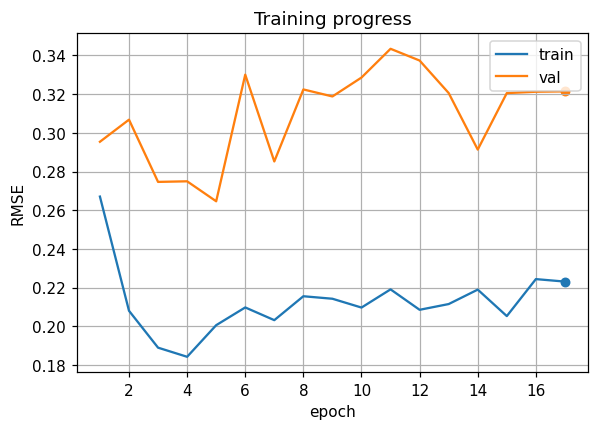

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2670 • val=0.2954 • lr=5.69e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2080 • val=0.3068 • lr=5.68e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1890 • val=0.2746 • lr=5.66e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1843 • val=0.2749 • lr=5.64e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2006 • val=0.2646 • lr=5.60e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2098 • val=0.3301 • lr=5.56e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2032 • val=0.2852 • lr=5.51e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2155 • val=0.3224 • lr=5.46e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2143 • val=0.3188 • lr=5.40e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2097 • val=0.3286 • lr=5.33e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2191 • val=0.3434 • lr=5.25e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2085 • val=0.3373 • lr=5.17e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2115 • val=0.3205 • lr=5.08e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2190 • val=0.2913 • lr=4.99e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2053 • val=0.3205 • lr=4.89e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2244 • val=0.3212 • lr=4.78e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2231 • val=0.3214 • lr=4.67e-03
Early stopping at epoch 17
Saved full model + hparams to dfs training/GOOGL_0.2646.pth


[I 2025-07-24 20:30:58,034] Trial 1 finished with value: 0.26461251001365005 and parameters: {'DROPOUT_SHORT': 0.18799488970779765, 'DROPOUT_LONG': 0.3116735139030016, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.1886740919887237, 'INITIAL_LR': 0.0056980199211651905, 'ETA_MIN': 0.0001481204648279154, 'WEIGHT_DECAY': 4.645356358082672e-05, 'CLIPNORM': 0.6475569820245177, 'LR_EPOCHS_WARMUP': 5}. Best is trial 1 with value: 0.26461251001365005.



▶ Trial 2 starting with:
{'DROPOUT_SHORT': 0.29960937544017563, 'DROPOUT_LONG': 0.31964415952386216, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.13597802531662279, 'INITIAL_LR': 0.04904282328687528, 'ETA_MIN': 0.00012404283414939584, 'WEIGHT_DECAY': 0.00025630798692080164, 'CLIPNORM': 0.5078271002416443, 'LR_EPOCHS_WARMUP': 1}



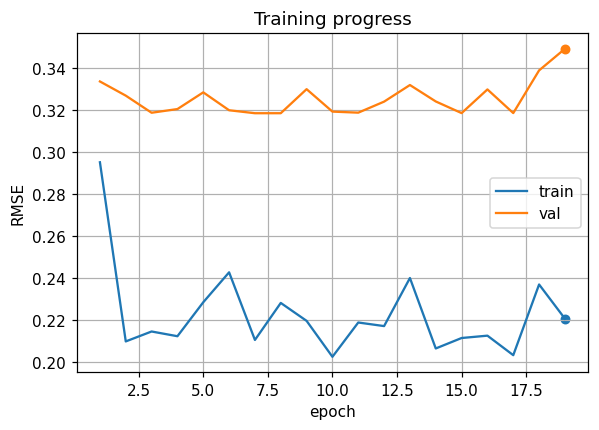

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2953 • val=0.3338 • lr=4.90e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2098 • val=0.3270 • lr=4.89e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2145 • val=0.3189 • lr=4.87e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2123 • val=0.3206 • lr=4.85e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2285 • val=0.3286 • lr=4.82e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2428 • val=0.3201 • lr=4.79e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2105 • val=0.3187 • lr=4.74e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2282 • val=0.3187 • lr=4.69e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2196 • val=0.3301 • lr=4.64e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2025 • val=0.3194 • lr=4.58e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2188 • val=0.3189 • lr=4.51e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2171 • val=0.3242 • lr=4.44e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2401 • val=0.3321 • lr=4.36e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2064 • val=0.3243 • lr=4.28e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2114 • val=0.3187 • lr=4.19e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2126 • val=0.3300 • lr=4.10e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2032 • val=0.3187 • lr=4.00e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2370 • val=0.3391 • lr=3.90e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2207 • val=0.3494 • lr=3.79e-02
Early stopping at epoch 19
Saved full model + hparams to dfs training/GOOGL_0.3187.pth


[I 2025-07-24 20:39:28,370] Trial 2 finished with value: 0.318651418044852 and parameters: {'DROPOUT_SHORT': 0.29960937544017563, 'DROPOUT_LONG': 0.31964415952386216, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.13597802531662279, 'INITIAL_LR': 0.04904282328687528, 'ETA_MIN': 0.00012404283414939584, 'WEIGHT_DECAY': 0.00025630798692080164, 'CLIPNORM': 0.5078271002416443, 'LR_EPOCHS_WARMUP': 1}. Best is trial 1 with value: 0.26461251001365005.



▶ Trial 3 starting with:
{'DROPOUT_SHORT': 0.33358687939731857, 'DROPOUT_LONG': 0.25677167995410977, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3134838756890783, 'INITIAL_LR': 0.004766904458949806, 'ETA_MIN': 4.3731864062794776e-05, 'WEIGHT_DECAY': 0.00036218814476370184, 'CLIPNORM': 0.8606690608389869, 'LR_EPOCHS_WARMUP': 11}



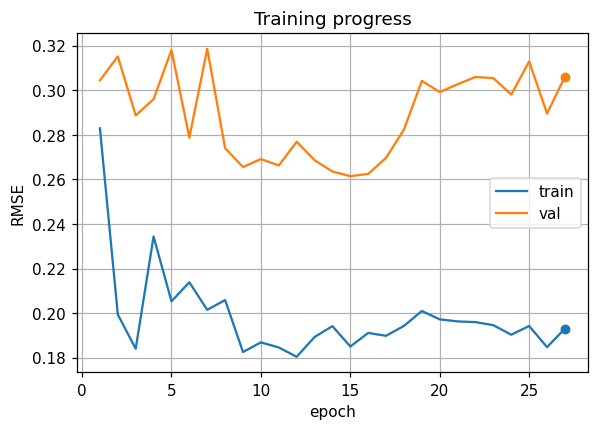

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2829 • val=0.3044 • lr=4.76e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1994 • val=0.3151 • lr=4.75e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1840 • val=0.2887 • lr=4.74e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2344 • val=0.2960 • lr=4.72e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2053 • val=0.3180 • lr=4.69e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2138 • val=0.2787 • lr=4.65e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2015 • val=0.3186 • lr=4.61e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2059 • val=0.2740 • lr=4.56e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1826 • val=0.2655 • lr=4.51e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1869 • val=0.2691 • lr=4.45e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1846 • val=0.2662 • lr=4.39e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1804 • val=0.2769 • lr=4.32e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1893 • val=0.2686 • lr=4.24e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1942 • val=0.2635 • lr=4.16e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1850 • val=0.2614 • lr=4.08e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1911 • val=0.2624 • lr=3.99e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1898 • val=0.2697 • lr=3.89e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1943 • val=0.2824 • lr=3.80e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2010 • val=0.3042 • lr=3.69e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1972 • val=0.2992 • lr=3.59e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1963 • val=0.3027 • lr=3.48e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1960 • val=0.3059 • lr=3.37e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1946 • val=0.3054 • lr=3.25e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1903 • val=0.2980 • lr=3.14e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1942 • val=0.3129 • lr=3.02e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1848 • val=0.2895 • lr=2.90e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1930 • val=0.3061 • lr=2.78e-03
Early stopping at epoch 27
Saved full model + hparams to dfs training/GOOGL_0.2614.pth


[I 2025-07-24 20:54:21,431] Trial 3 finished with value: 0.261446740215707 and parameters: {'DROPOUT_SHORT': 0.33358687939731857, 'DROPOUT_LONG': 0.25677167995410977, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3134838756890783, 'INITIAL_LR': 0.004766904458949806, 'ETA_MIN': 4.3731864062794776e-05, 'WEIGHT_DECAY': 0.00036218814476370184, 'CLIPNORM': 0.8606690608389869, 'LR_EPOCHS_WARMUP': 11}. Best is trial 3 with value: 0.261446740215707.



▶ Trial 4 starting with:
{'DROPOUT_SHORT': 0.26056672841987644, 'DROPOUT_LONG': 0.20095187099349832, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.28574771817391814, 'INITIAL_LR': 0.03954040040728235, 'ETA_MIN': 0.0004855364958360008, 'WEIGHT_DECAY': 3.050724253371046e-05, 'CLIPNORM': 0.5963864736470037, 'LR_EPOCHS_WARMUP': 1}



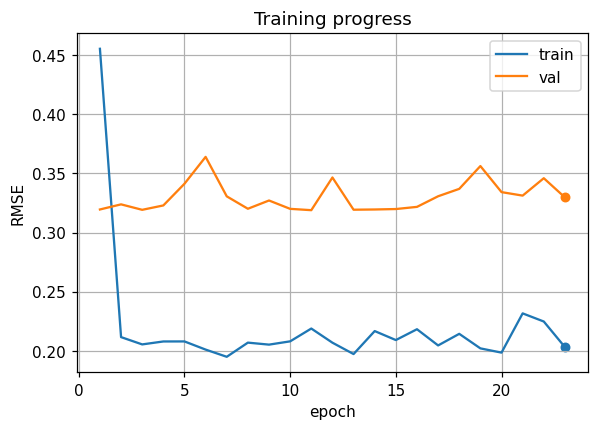

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4554 • val=0.3195 • lr=3.95e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2116 • val=0.3238 • lr=3.94e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2054 • val=0.3192 • lr=3.93e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2079 • val=0.3229 • lr=3.91e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2079 • val=0.3413 • lr=3.89e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2010 • val=0.3640 • lr=3.86e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1949 • val=0.3306 • lr=3.82e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2069 • val=0.3201 • lr=3.79e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2052 • val=0.3271 • lr=3.74e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2080 • val=0.3200 • lr=3.69e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2188 • val=0.3189 • lr=3.64e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2068 • val=0.3465 • lr=3.58e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1972 • val=0.3193 • lr=3.52e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2167 • val=0.3195 • lr=3.45e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2091 • val=0.3199 • lr=3.38e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2182 • val=0.3217 • lr=3.31e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2045 • val=0.3307 • lr=3.23e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2143 • val=0.3369 • lr=3.15e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2020 • val=0.3562 • lr=3.07e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1985 • val=0.3342 • lr=2.98e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2316 • val=0.3312 • lr=2.89e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2248 • val=0.3459 • lr=2.80e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2031 • val=0.3297 • lr=2.70e-02
Early stopping at epoch 23
Saved full model + hparams to dfs training/GOOGL_0.3189.pth


[I 2025-07-24 21:05:02,807] Trial 4 finished with value: 0.3189027207667447 and parameters: {'DROPOUT_SHORT': 0.26056672841987644, 'DROPOUT_LONG': 0.20095187099349832, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.28574771817391814, 'INITIAL_LR': 0.03954040040728235, 'ETA_MIN': 0.0004855364958360008, 'WEIGHT_DECAY': 3.050724253371046e-05, 'CLIPNORM': 0.5963864736470037, 'LR_EPOCHS_WARMUP': 1}. Best is trial 3 with value: 0.261446740215707.



▶ Trial 5 starting with:
{'DROPOUT_SHORT': 0.19911813879991938, 'DROPOUT_LONG': 0.3712046117985721, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2611765798458385, 'INITIAL_LR': 0.02396815937014416, 'ETA_MIN': 7.887626570061898e-07, 'WEIGHT_DECAY': 0.00030955662315813203, 'CLIPNORM': 0.3703163410445046, 'LR_EPOCHS_WARMUP': 10}



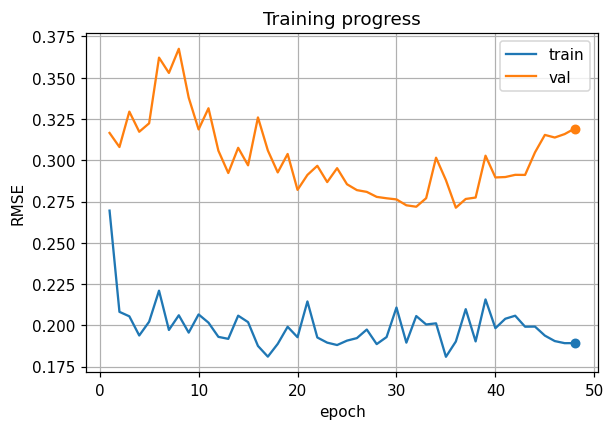

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2695 • val=0.3166 • lr=2.40e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2082 • val=0.3080 • lr=2.39e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2055 • val=0.3295 • lr=2.38e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1939 • val=0.3173 • lr=2.37e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2022 • val=0.3224 • lr=2.36e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2211 • val=0.3622 • lr=2.34e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1973 • val=0.3529 • lr=2.32e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2062 • val=0.3675 • lr=2.29e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1957 • val=0.3379 • lr=2.27e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2067 • val=0.3187 • lr=2.24e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2017 • val=0.3315 • lr=2.20e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1931 • val=0.3058 • lr=2.17e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1919 • val=0.2923 • lr=2.13e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2059 • val=0.3076 • lr=2.09e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2020 • val=0.2970 • lr=2.05e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1876 • val=0.3260 • lr=2.00e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1811 • val=0.3060 • lr=1.95e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1889 • val=0.2927 • lr=1.90e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1992 • val=0.3038 • lr=1.85e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1929 • val=0.2821 • lr=1.80e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2145 • val=0.2912 • lr=1.74e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1927 • val=0.2967 • lr=1.69e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1896 • val=0.2868 • lr=1.63e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1881 • val=0.2952 • lr=1.57e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1908 • val=0.2855 • lr=1.51e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1923 • val=0.2820 • lr=1.45e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1975 • val=0.2809 • lr=1.39e-02


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1887 • val=0.2779 • lr=1.32e-02


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1930 • val=0.2770 • lr=1.26e-02


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2109 • val=0.2763 • lr=1.20e-02


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1896 • val=0.2728 • lr=1.14e-02


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2057 • val=0.2719 • lr=1.07e-02


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2006 • val=0.2771 • lr=1.01e-02


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2013 • val=0.3016 • lr=9.50e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1810 • val=0.2880 • lr=8.89e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1903 • val=0.2713 • lr=8.29e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2099 • val=0.2766 • lr=7.70e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1903 • val=0.2775 • lr=7.12e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.2158 • val=0.3028 • lr=6.55e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.1983 • val=0.2896 • lr=6.00e-03


Epoch 41:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 041 • train=0.2041 • val=0.2899 • lr=5.47e-03


Epoch 42:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 042 • train=0.2059 • val=0.2912 • lr=4.95e-03


Epoch 43:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 043 • train=0.1992 • val=0.2912 • lr=4.45e-03


Epoch 44:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 044 • train=0.1993 • val=0.3048 • lr=3.97e-03


Epoch 45:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 045 • train=0.1938 • val=0.3154 • lr=3.52e-03


Epoch 46:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 046 • train=0.1905 • val=0.3138 • lr=3.09e-03


Epoch 47:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 047 • train=0.1893 • val=0.3159 • lr=2.68e-03


Epoch 48:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 048 • train=0.1893 • val=0.3192 • lr=2.30e-03
Early stopping at epoch 48
Saved full model + hparams to dfs training/GOOGL_0.2713.pth


[I 2025-07-24 21:39:19,673] Trial 5 finished with value: 0.27130708375472096 and parameters: {'DROPOUT_SHORT': 0.19911813879991938, 'DROPOUT_LONG': 0.3712046117985721, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2611765798458385, 'INITIAL_LR': 0.02396815937014416, 'ETA_MIN': 7.887626570061898e-07, 'WEIGHT_DECAY': 0.00030955662315813203, 'CLIPNORM': 0.3703163410445046, 'LR_EPOCHS_WARMUP': 10}. Best is trial 3 with value: 0.261446740215707.



▶ Trial 6 starting with:
{'DROPOUT_SHORT': 0.22362100046153424, 'DROPOUT_LONG': 0.27285394134592117, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.28569405794035835, 'INITIAL_LR': 0.020704579131067578, 'ETA_MIN': 0.0004969783363243221, 'WEIGHT_DECAY': 0.00047315924366346247, 'CLIPNORM': 0.8528777657263258, 'LR_EPOCHS_WARMUP': 8}



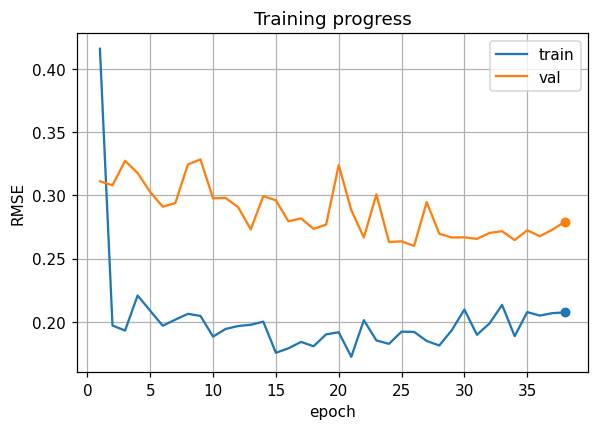

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4160 • val=0.3111 • lr=2.07e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1971 • val=0.3081 • lr=2.07e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1931 • val=0.3274 • lr=2.06e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2208 • val=0.3177 • lr=2.05e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2087 • val=0.3027 • lr=2.04e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1969 • val=0.2911 • lr=2.02e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2017 • val=0.2939 • lr=2.00e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2063 • val=0.3245 • lr=1.98e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2047 • val=0.3285 • lr=1.96e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1883 • val=0.2977 • lr=1.94e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1943 • val=0.2980 • lr=1.91e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1967 • val=0.2907 • lr=1.88e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1977 • val=0.2731 • lr=1.85e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2001 • val=0.2995 • lr=1.81e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1755 • val=0.2961 • lr=1.78e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1790 • val=0.2795 • lr=1.74e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1841 • val=0.2818 • lr=1.70e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1806 • val=0.2736 • lr=1.65e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1901 • val=0.2769 • lr=1.61e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1918 • val=0.3241 • lr=1.57e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1723 • val=0.2884 • lr=1.52e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2013 • val=0.2667 • lr=1.47e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1853 • val=0.3008 • lr=1.42e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1826 • val=0.2631 • lr=1.37e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1922 • val=0.2637 • lr=1.32e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1920 • val=0.2601 • lr=1.27e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1849 • val=0.2947 • lr=1.22e-02


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1812 • val=0.2697 • lr=1.17e-02


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1934 • val=0.2667 • lr=1.11e-02


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2097 • val=0.2669 • lr=1.06e-02


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1897 • val=0.2656 • lr=1.01e-02


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1987 • val=0.2703 • lr=9.55e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2134 • val=0.2717 • lr=9.03e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1886 • val=0.2647 • lr=8.51e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2077 • val=0.2724 • lr=7.99e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2049 • val=0.2677 • lr=7.49e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2069 • val=0.2729 • lr=6.99e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.2074 • val=0.2792 • lr=6.50e-03
Early stopping at epoch 38
Saved full model + hparams to dfs training/GOOGL_0.2601.pth


[I 2025-07-24 22:06:30,097] Trial 6 finished with value: 0.26006292450907315 and parameters: {'DROPOUT_SHORT': 0.22362100046153424, 'DROPOUT_LONG': 0.27285394134592117, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.28569405794035835, 'INITIAL_LR': 0.020704579131067578, 'ETA_MIN': 0.0004969783363243221, 'WEIGHT_DECAY': 0.00047315924366346247, 'CLIPNORM': 0.8528777657263258, 'LR_EPOCHS_WARMUP': 8}. Best is trial 6 with value: 0.26006292450907315.



▶ Trial 7 starting with:
{'DROPOUT_SHORT': 0.28927982178723965, 'DROPOUT_LONG': 0.28038732540087474, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3429797797365809, 'INITIAL_LR': 0.0267743382689452, 'ETA_MIN': 0.00016605982361213645, 'WEIGHT_DECAY': 9.947287265180913e-06, 'CLIPNORM': 0.3087449377539084, 'LR_EPOCHS_WARMUP': 11}



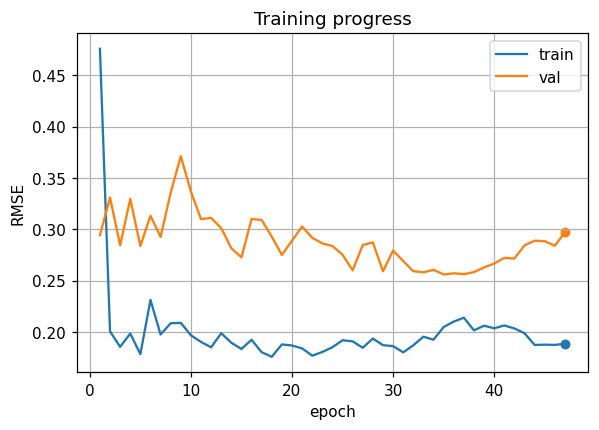

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4757 • val=0.2941 • lr=2.68e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2004 • val=0.3309 • lr=2.67e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1854 • val=0.2843 • lr=2.66e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1983 • val=0.3295 • lr=2.65e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1783 • val=0.2836 • lr=2.63e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2311 • val=0.3131 • lr=2.61e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1974 • val=0.2924 • lr=2.59e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2084 • val=0.3356 • lr=2.56e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2087 • val=0.3711 • lr=2.53e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1966 • val=0.3367 • lr=2.50e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1902 • val=0.3097 • lr=2.46e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1849 • val=0.3111 • lr=2.42e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1987 • val=0.3010 • lr=2.38e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1893 • val=0.2814 • lr=2.34e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1833 • val=0.2725 • lr=2.29e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1923 • val=0.3099 • lr=2.24e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1801 • val=0.3090 • lr=2.19e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1757 • val=0.2926 • lr=2.13e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1878 • val=0.2749 • lr=2.07e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1867 • val=0.2888 • lr=2.01e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1839 • val=0.3026 • lr=1.95e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1768 • val=0.2916 • lr=1.89e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1804 • val=0.2862 • lr=1.82e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1850 • val=0.2836 • lr=1.76e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1918 • val=0.2751 • lr=1.69e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1907 • val=0.2600 • lr=1.62e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1845 • val=0.2845 • lr=1.56e-02


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1934 • val=0.2871 • lr=1.49e-02


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1870 • val=0.2590 • lr=1.42e-02


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1861 • val=0.2792 • lr=1.35e-02


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1800 • val=0.2690 • lr=1.28e-02


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1869 • val=0.2591 • lr=1.21e-02


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1953 • val=0.2579 • lr=1.14e-02


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1924 • val=0.2604 • lr=1.07e-02


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2047 • val=0.2559 • lr=1.00e-02


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2100 • val=0.2570 • lr=9.37e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2138 • val=0.2562 • lr=8.71e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.2015 • val=0.2582 • lr=8.07e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.2060 • val=0.2628 • lr=7.44e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.2035 • val=0.2664 • lr=6.83e-03


Epoch 41:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 041 • train=0.2062 • val=0.2720 • lr=6.23e-03


Epoch 42:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 042 • train=0.2033 • val=0.2714 • lr=5.66e-03


Epoch 43:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 043 • train=0.1987 • val=0.2842 • lr=5.11e-03


Epoch 44:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 044 • train=0.1872 • val=0.2888 • lr=4.58e-03


Epoch 45:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 045 • train=0.1875 • val=0.2883 • lr=4.07e-03


Epoch 46:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 046 • train=0.1873 • val=0.2838 • lr=3.59e-03


Epoch 47:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 047 • train=0.1884 • val=0.2970 • lr=3.14e-03
Early stopping at epoch 47
Saved full model + hparams to dfs training/GOOGL_0.2559.pth


[I 2025-07-24 22:40:14,838] Trial 7 finished with value: 0.2558724852856882 and parameters: {'DROPOUT_SHORT': 0.28927982178723965, 'DROPOUT_LONG': 0.28038732540087474, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3429797797365809, 'INITIAL_LR': 0.0267743382689452, 'ETA_MIN': 0.00016605982361213645, 'WEIGHT_DECAY': 9.947287265180913e-06, 'CLIPNORM': 0.3087449377539084, 'LR_EPOCHS_WARMUP': 11}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 8 starting with:
{'DROPOUT_SHORT': 0.22459654027260112, 'DROPOUT_LONG': 0.39760853261925927, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2664931407184422, 'INITIAL_LR': 0.00860117557288757, 'ETA_MIN': 0.00014578781542619, 'WEIGHT_DECAY': 0.00043013443014722436, 'CLIPNORM': 0.353467275001112, 'LR_EPOCHS_WARMUP': 11}



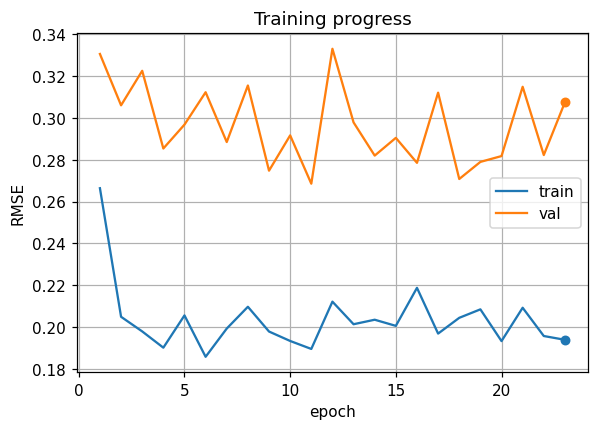

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2664 • val=0.3306 • lr=8.60e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2049 • val=0.3060 • lr=8.58e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1979 • val=0.3225 • lr=8.55e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1902 • val=0.2854 • lr=8.51e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2056 • val=0.2968 • lr=8.46e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1858 • val=0.3123 • lr=8.40e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1993 • val=0.2885 • lr=8.32e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2097 • val=0.3155 • lr=8.24e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1979 • val=0.2748 • lr=8.14e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1934 • val=0.2916 • lr=8.04e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1895 • val=0.2685 • lr=7.92e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2122 • val=0.3330 • lr=7.80e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2014 • val=0.2978 • lr=7.66e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2035 • val=0.2820 • lr=7.52e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2006 • val=0.2905 • lr=7.37e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2188 • val=0.2785 • lr=7.21e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1969 • val=0.3121 • lr=7.04e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2044 • val=0.2708 • lr=6.86e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2085 • val=0.2790 • lr=6.68e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1933 • val=0.2818 • lr=6.49e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2092 • val=0.3149 • lr=6.30e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1957 • val=0.2822 • lr=6.10e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1939 • val=0.3075 • lr=5.89e-03
Early stopping at epoch 23
Saved full model + hparams to dfs training/GOOGL_0.2685.pth


[I 2025-07-24 22:53:02,349] Trial 8 finished with value: 0.2685499149312239 and parameters: {'DROPOUT_SHORT': 0.22459654027260112, 'DROPOUT_LONG': 0.39760853261925927, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2664931407184422, 'INITIAL_LR': 0.00860117557288757, 'ETA_MIN': 0.00014578781542619, 'WEIGHT_DECAY': 0.00043013443014722436, 'CLIPNORM': 0.353467275001112, 'LR_EPOCHS_WARMUP': 11}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 9 starting with:
{'DROPOUT_SHORT': 0.23934445480206337, 'DROPOUT_LONG': 0.41879770492152024, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.37913150538341023, 'INITIAL_LR': 0.011665992977628253, 'ETA_MIN': 0.0002649551737512781, 'WEIGHT_DECAY': 8.793822949125828e-05, 'CLIPNORM': 0.588327457089505, 'LR_EPOCHS_WARMUP': 12}



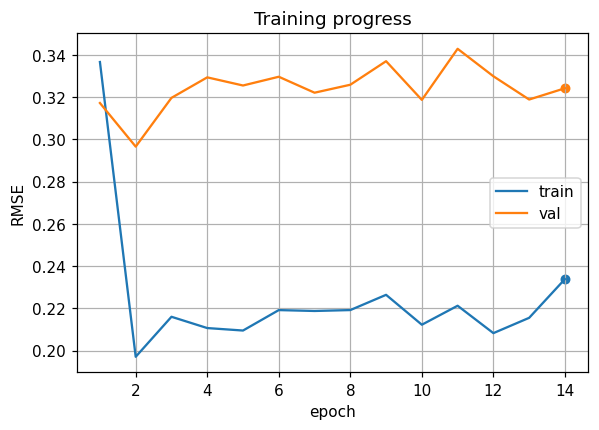

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3366 • val=0.3172 • lr=1.17e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1970 • val=0.2965 • lr=1.16e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2160 • val=0.3196 • lr=1.16e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2106 • val=0.3293 • lr=1.15e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2095 • val=0.3255 • lr=1.15e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2191 • val=0.3296 • lr=1.14e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2187 • val=0.3221 • lr=1.13e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2192 • val=0.3258 • lr=1.12e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2264 • val=0.3370 • lr=1.10e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2122 • val=0.3187 • lr=1.09e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2212 • val=0.3428 • lr=1.07e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2082 • val=0.3298 • lr=1.06e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2155 • val=0.3188 • lr=1.04e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2338 • val=0.3242 • lr=1.02e-02
Early stopping at epoch 14
Saved full model + hparams to dfs training/GOOGL_0.2965.pth


[I 2025-07-24 23:03:09,909] Trial 9 finished with value: 0.29653984049737525 and parameters: {'DROPOUT_SHORT': 0.23934445480206337, 'DROPOUT_LONG': 0.41879770492152024, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.37913150538341023, 'INITIAL_LR': 0.011665992977628253, 'ETA_MIN': 0.0002649551737512781, 'WEIGHT_DECAY': 8.793822949125828e-05, 'CLIPNORM': 0.588327457089505, 'LR_EPOCHS_WARMUP': 12}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 10 starting with:
{'DROPOUT_SHORT': 0.27654362007236344, 'DROPOUT_LONG': 0.20192158898692958, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.38793823495309554, 'INITIAL_LR': 0.03156157387820957, 'ETA_MIN': 0.00031385034456147995, 'WEIGHT_DECAY': 0.00017885484672142008, 'CLIPNORM': 0.30717636796448355, 'LR_EPOCHS_WARMUP': 4}



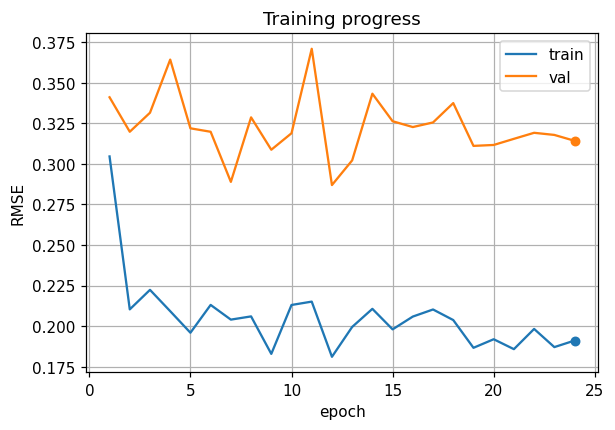

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3046 • val=0.3411 • lr=3.15e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2104 • val=0.3198 • lr=3.15e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2224 • val=0.3315 • lr=3.14e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2092 • val=0.3643 • lr=3.12e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1960 • val=0.3219 • lr=3.10e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2131 • val=0.3198 • lr=3.08e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2040 • val=0.2889 • lr=3.05e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2060 • val=0.3287 • lr=3.02e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1829 • val=0.3087 • lr=2.99e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2131 • val=0.3189 • lr=2.95e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2151 • val=0.3709 • lr=2.90e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1811 • val=0.2870 • lr=2.86e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1995 • val=0.3022 • lr=2.81e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2107 • val=0.3433 • lr=2.76e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1980 • val=0.3263 • lr=2.70e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2059 • val=0.3227 • lr=2.64e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2103 • val=0.3255 • lr=2.58e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2038 • val=0.3375 • lr=2.51e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1867 • val=0.3111 • lr=2.45e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1919 • val=0.3117 • lr=2.38e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1858 • val=0.3154 • lr=2.30e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1983 • val=0.3192 • lr=2.23e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1871 • val=0.3179 • lr=2.15e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1911 • val=0.3142 • lr=2.08e-02
Early stopping at epoch 24
Saved full model + hparams to dfs training/GOOGL_0.2870.pth


[I 2025-07-24 23:20:21,437] Trial 10 finished with value: 0.28696252992025706 and parameters: {'DROPOUT_SHORT': 0.27654362007236344, 'DROPOUT_LONG': 0.20192158898692958, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.38793823495309554, 'INITIAL_LR': 0.03156157387820957, 'ETA_MIN': 0.00031385034456147995, 'WEIGHT_DECAY': 0.00017885484672142008, 'CLIPNORM': 0.30717636796448355, 'LR_EPOCHS_WARMUP': 4}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 11 starting with:
{'DROPOUT_SHORT': 0.15094805301313885, 'DROPOUT_LONG': 0.26513283564109424, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.33426064546875944, 'INITIAL_LR': 0.020168316326814643, 'ETA_MIN': 0.000374205851087119, 'WEIGHT_DECAY': 0.00017760313903808332, 'CLIPNORM': 0.9909757545103948, 'LR_EPOCHS_WARMUP': 8}



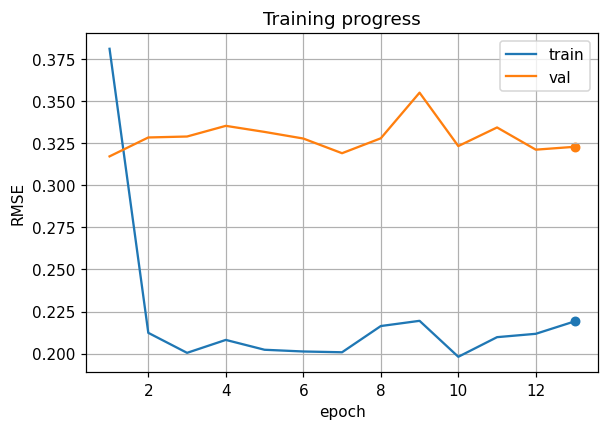

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3810 • val=0.3171 • lr=2.02e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2124 • val=0.3283 • lr=2.01e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2005 • val=0.3289 • lr=2.00e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2082 • val=0.3352 • lr=2.00e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2023 • val=0.3316 • lr=1.98e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2013 • val=0.3277 • lr=1.97e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2009 • val=0.3190 • lr=1.95e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2164 • val=0.3279 • lr=1.93e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2195 • val=0.3549 • lr=1.91e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1982 • val=0.3232 • lr=1.88e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2098 • val=0.3343 • lr=1.86e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2118 • val=0.3211 • lr=1.83e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2192 • val=0.3228 • lr=1.80e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3171.pth


[I 2025-07-24 23:29:34,235] Trial 11 finished with value: 0.31712111856890596 and parameters: {'DROPOUT_SHORT': 0.15094805301313885, 'DROPOUT_LONG': 0.26513283564109424, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.33426064546875944, 'INITIAL_LR': 0.020168316326814643, 'ETA_MIN': 0.000374205851087119, 'WEIGHT_DECAY': 0.00017760313903808332, 'CLIPNORM': 0.9909757545103948, 'LR_EPOCHS_WARMUP': 8}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 12 starting with:
{'DROPOUT_SHORT': 0.2880654510651042, 'DROPOUT_LONG': 0.26205032288487, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.21659459027872635, 'INITIAL_LR': 0.01705567462330501, 'ETA_MIN': 0.0002133073693865231, 'WEIGHT_DECAY': 0.00014701382135785931, 'CLIPNORM': 0.7816984146824195, 'LR_EPOCHS_WARMUP': 8}



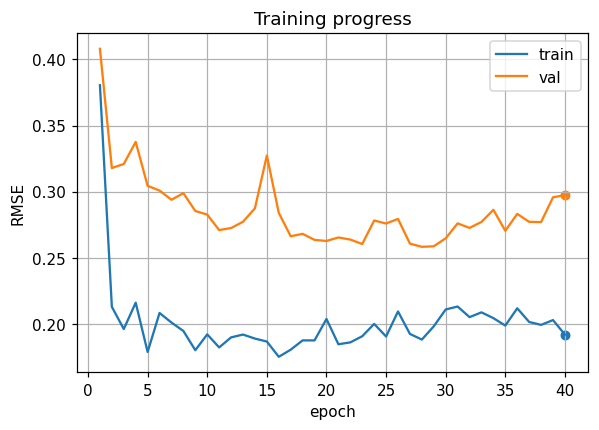

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3805 • val=0.4080 • lr=1.70e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2129 • val=0.3179 • lr=1.70e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1961 • val=0.3209 • lr=1.70e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2160 • val=0.3376 • lr=1.69e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1787 • val=0.3044 • lr=1.68e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2082 • val=0.3008 • lr=1.66e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2010 • val=0.2939 • lr=1.65e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1946 • val=0.2988 • lr=1.63e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1801 • val=0.2854 • lr=1.61e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1920 • val=0.2826 • lr=1.59e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1822 • val=0.2709 • lr=1.57e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1898 • val=0.2725 • lr=1.55e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1919 • val=0.2772 • lr=1.52e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1889 • val=0.2874 • lr=1.49e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1866 • val=0.3273 • lr=1.46e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1751 • val=0.2839 • lr=1.43e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1805 • val=0.2662 • lr=1.39e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1875 • val=0.2681 • lr=1.36e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1875 • val=0.2635 • lr=1.32e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2037 • val=0.2627 • lr=1.29e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1846 • val=0.2653 • lr=1.25e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1860 • val=0.2638 • lr=1.21e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1906 • val=0.2604 • lr=1.17e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2000 • val=0.2782 • lr=1.12e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1904 • val=0.2759 • lr=1.08e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2094 • val=0.2794 • lr=1.04e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1924 • val=0.2607 • lr=9.96e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1881 • val=0.2583 • lr=9.52e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1981 • val=0.2587 • lr=9.08e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2109 • val=0.2647 • lr=8.64e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2131 • val=0.2760 • lr=8.20e-03


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2051 • val=0.2726 • lr=7.76e-03


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2087 • val=0.2771 • lr=7.32e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.2043 • val=0.2863 • lr=6.89e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1987 • val=0.2704 • lr=6.46e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2118 • val=0.2832 • lr=6.04e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2014 • val=0.2771 • lr=5.62e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1992 • val=0.2770 • lr=5.22e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.2029 • val=0.2957 • lr=4.82e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.1919 • val=0.2974 • lr=4.43e-03
Early stopping at epoch 40
Saved full model + hparams to dfs training/GOOGL_0.2583.pth


[I 2025-07-24 23:57:52,207] Trial 12 finished with value: 0.2582593635403211 and parameters: {'DROPOUT_SHORT': 0.2880654510651042, 'DROPOUT_LONG': 0.26205032288487, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.21659459027872635, 'INITIAL_LR': 0.01705567462330501, 'ETA_MIN': 0.0002133073693865231, 'WEIGHT_DECAY': 0.00014701382135785931, 'CLIPNORM': 0.7816984146824195, 'LR_EPOCHS_WARMUP': 8}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 13 starting with:
{'DROPOUT_SHORT': 0.288882489098944, 'DROPOUT_LONG': 0.23418107714212383, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2079916032972863, 'INITIAL_LR': 0.015339268505531252, 'ETA_MIN': 0.00021667085222023047, 'WEIGHT_DECAY': 0.00014486092616651706, 'CLIPNORM': 0.7495460319778156, 'LR_EPOCHS_WARMUP': 9}



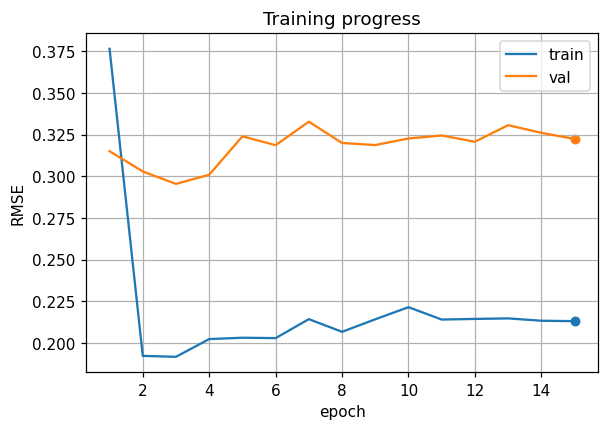

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3765 • val=0.3150 • lr=1.53e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1921 • val=0.3029 • lr=1.53e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1916 • val=0.2954 • lr=1.52e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2022 • val=0.3009 • lr=1.52e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2030 • val=0.3240 • lr=1.51e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2028 • val=0.3187 • lr=1.50e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2142 • val=0.3328 • lr=1.48e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2066 • val=0.3200 • lr=1.47e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2141 • val=0.3187 • lr=1.45e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2214 • val=0.3227 • lr=1.43e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2139 • val=0.3245 • lr=1.41e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2143 • val=0.3207 • lr=1.39e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2146 • val=0.3307 • lr=1.37e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2132 • val=0.3261 • lr=1.34e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2130 • val=0.3224 • lr=1.31e-02
Early stopping at epoch 15
Saved full model + hparams to dfs training/GOOGL_0.2954.pth


[I 2025-07-25 00:08:34,415] Trial 13 finished with value: 0.29542031307809813 and parameters: {'DROPOUT_SHORT': 0.288882489098944, 'DROPOUT_LONG': 0.23418107714212383, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2079916032972863, 'INITIAL_LR': 0.015339268505531252, 'ETA_MIN': 0.00021667085222023047, 'WEIGHT_DECAY': 0.00014486092616651706, 'CLIPNORM': 0.7495460319778156, 'LR_EPOCHS_WARMUP': 9}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 14 starting with:
{'DROPOUT_SHORT': 0.34156857757722964, 'DROPOUT_LONG': 0.3626019864369129, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.10370376847212276, 'INITIAL_LR': 0.030570841178343584, 'ETA_MIN': 0.00022050666287414466, 'WEIGHT_DECAY': 5.301204163593511e-06, 'CLIPNORM': 0.46312831212913547, 'LR_EPOCHS_WARMUP': 6}



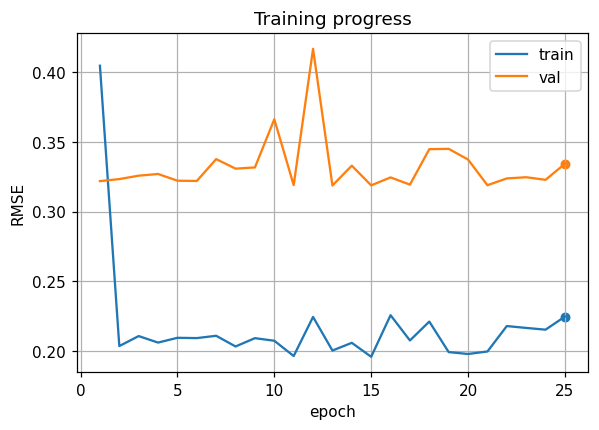

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4048 • val=0.3220 • lr=3.06e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2035 • val=0.3234 • lr=3.05e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2106 • val=0.3258 • lr=3.04e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2060 • val=0.3271 • lr=3.02e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2094 • val=0.3222 • lr=3.01e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2092 • val=0.3221 • lr=2.98e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2109 • val=0.3378 • lr=2.96e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2032 • val=0.3309 • lr=2.93e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2091 • val=0.3318 • lr=2.89e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2073 • val=0.3664 • lr=2.85e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1963 • val=0.3191 • lr=2.81e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2244 • val=0.4170 • lr=2.77e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2003 • val=0.3188 • lr=2.72e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2058 • val=0.3330 • lr=2.67e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1958 • val=0.3189 • lr=2.61e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2256 • val=0.3246 • lr=2.56e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2075 • val=0.3194 • lr=2.50e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2210 • val=0.3449 • lr=2.43e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1991 • val=0.3451 • lr=2.37e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1978 • val=0.3374 • lr=2.30e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1996 • val=0.3190 • lr=2.23e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2178 • val=0.3239 • lr=2.16e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2165 • val=0.3247 • lr=2.08e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2152 • val=0.3229 • lr=2.01e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2246 • val=0.3344 • lr=1.93e-02
Early stopping at epoch 25
Saved full model + hparams to dfs training/GOOGL_0.3188.pth


[I 2025-07-25 00:26:20,907] Trial 14 finished with value: 0.3187910273775187 and parameters: {'DROPOUT_SHORT': 0.34156857757722964, 'DROPOUT_LONG': 0.3626019864369129, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.10370376847212276, 'INITIAL_LR': 0.030570841178343584, 'ETA_MIN': 0.00022050666287414466, 'WEIGHT_DECAY': 5.301204163593511e-06, 'CLIPNORM': 0.46312831212913547, 'LR_EPOCHS_WARMUP': 6}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 15 starting with:
{'DROPOUT_SHORT': 0.3124164663730344, 'DROPOUT_LONG': 0.28914699188752124, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.21689221557056362, 'INITIAL_LR': 0.03217278961119715, 'ETA_MIN': 8.287927897429298e-05, 'WEIGHT_DECAY': 0.000111124074010398, 'CLIPNORM': 0.7355170301799684, 'LR_EPOCHS_WARMUP': 12}



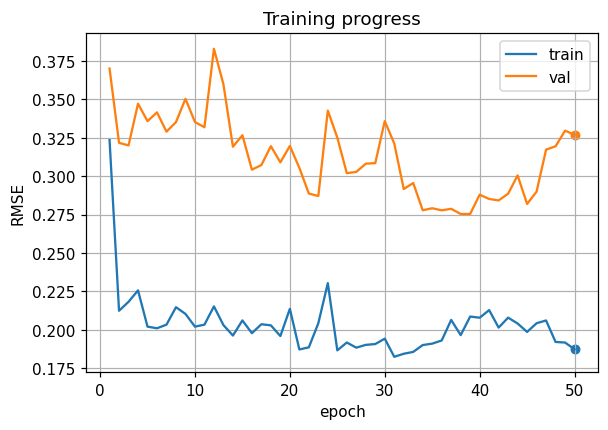

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3235 • val=0.3701 • lr=3.22e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2124 • val=0.3217 • lr=3.21e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2183 • val=0.3201 • lr=3.20e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2257 • val=0.3472 • lr=3.18e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2021 • val=0.3358 • lr=3.16e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2010 • val=0.3416 • lr=3.14e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2034 • val=0.3290 • lr=3.11e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2147 • val=0.3352 • lr=3.08e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2104 • val=0.3504 • lr=3.04e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2021 • val=0.3353 • lr=3.00e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2034 • val=0.3319 • lr=2.96e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2153 • val=0.3829 • lr=2.91e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2031 • val=0.3598 • lr=2.86e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1963 • val=0.3192 • lr=2.81e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2061 • val=0.3267 • lr=2.75e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1978 • val=0.3043 • lr=2.69e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2036 • val=0.3073 • lr=2.62e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2029 • val=0.3196 • lr=2.56e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1960 • val=0.3090 • lr=2.49e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2137 • val=0.3197 • lr=2.42e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1872 • val=0.3055 • lr=2.34e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1886 • val=0.2887 • lr=2.27e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2043 • val=0.2871 • lr=2.19e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2304 • val=0.3427 • lr=2.11e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1866 • val=0.3251 • lr=2.03e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1918 • val=0.3020 • lr=1.95e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1884 • val=0.3028 • lr=1.87e-02


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1902 • val=0.3082 • lr=1.78e-02


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1907 • val=0.3085 • lr=1.70e-02


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1943 • val=0.3359 • lr=1.61e-02


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1824 • val=0.3213 • lr=1.53e-02


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1844 • val=0.2917 • lr=1.45e-02


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1856 • val=0.2956 • lr=1.36e-02


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1901 • val=0.2778 • lr=1.28e-02


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.1910 • val=0.2791 • lr=1.20e-02


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.1931 • val=0.2778 • lr=1.12e-02


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2065 • val=0.2788 • lr=1.04e-02


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.1966 • val=0.2754 • lr=9.61e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.2086 • val=0.2754 • lr=8.86e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.2079 • val=0.2880 • lr=8.12e-03


Epoch 41:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 041 • train=0.2128 • val=0.2852 • lr=7.40e-03


Epoch 42:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 042 • train=0.2015 • val=0.2842 • lr=6.71e-03


Epoch 43:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 043 • train=0.2079 • val=0.2886 • lr=6.04e-03


Epoch 44:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 044 • train=0.2041 • val=0.3005 • lr=5.40e-03


Epoch 45:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 045 • train=0.1986 • val=0.2820 • lr=4.79e-03


Epoch 46:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 046 • train=0.2043 • val=0.2900 • lr=4.21e-03


Epoch 47:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 047 • train=0.2061 • val=0.3173 • lr=3.67e-03


Epoch 48:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 048 • train=0.1921 • val=0.3195 • lr=3.16e-03


Epoch 49:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 049 • train=0.1917 • val=0.3297 • lr=2.68e-03


Epoch 50:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 050 • train=0.1873 • val=0.3269 • lr=2.24e-03
Early stopping at epoch 50
Saved full model + hparams to dfs training/GOOGL_0.2754.pth


[I 2025-07-25 01:01:55,497] Trial 15 finished with value: 0.27542763301759 and parameters: {'DROPOUT_SHORT': 0.3124164663730344, 'DROPOUT_LONG': 0.28914699188752124, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.21689221557056362, 'INITIAL_LR': 0.03217278961119715, 'ETA_MIN': 8.287927897429298e-05, 'WEIGHT_DECAY': 0.000111124074010398, 'CLIPNORM': 0.7355170301799684, 'LR_EPOCHS_WARMUP': 12}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 16 starting with:
{'DROPOUT_SHORT': 0.26632556271526864, 'DROPOUT_LONG': 0.34805685670098574, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.34481740850756126, 'INITIAL_LR': 0.015198189731300703, 'ETA_MIN': 0.0003092501551344233, 'WEIGHT_DECAY': 0.0002282051806919609, 'CLIPNORM': 0.936728379821669, 'LR_EPOCHS_WARMUP': 3}



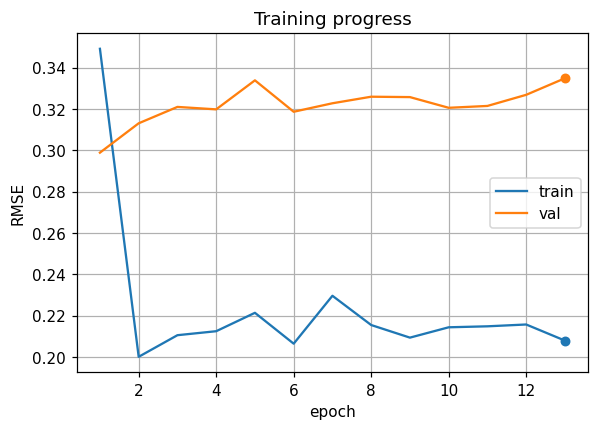

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3491 • val=0.2989 • lr=1.52e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2000 • val=0.3131 • lr=1.52e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2105 • val=0.3210 • lr=1.51e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2124 • val=0.3198 • lr=1.50e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2213 • val=0.3339 • lr=1.49e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2064 • val=0.3187 • lr=1.48e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2296 • val=0.3228 • lr=1.47e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2154 • val=0.3259 • lr=1.46e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2093 • val=0.3257 • lr=1.44e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2143 • val=0.3206 • lr=1.42e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2148 • val=0.3215 • lr=1.40e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2157 • val=0.3269 • lr=1.38e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2079 • val=0.3349 • lr=1.35e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.2989.pth


[I 2025-07-25 01:08:08,077] Trial 16 finished with value: 0.29885735513659495 and parameters: {'DROPOUT_SHORT': 0.26632556271526864, 'DROPOUT_LONG': 0.34805685670098574, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.34481740850756126, 'INITIAL_LR': 0.015198189731300703, 'ETA_MIN': 0.0003092501551344233, 'WEIGHT_DECAY': 0.0002282051806919609, 'CLIPNORM': 0.936728379821669, 'LR_EPOCHS_WARMUP': 3}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 17 starting with:
{'DROPOUT_SHORT': 0.2861747765766648, 'DROPOUT_LONG': 0.23374264963024943, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.23516316141933935, 'INITIAL_LR': 0.0009573269412491425, 'ETA_MIN': 0.0001881236880201239, 'WEIGHT_DECAY': 8.293066812154035e-05, 'CLIPNORM': 0.47551289554246257, 'LR_EPOCHS_WARMUP': 7}



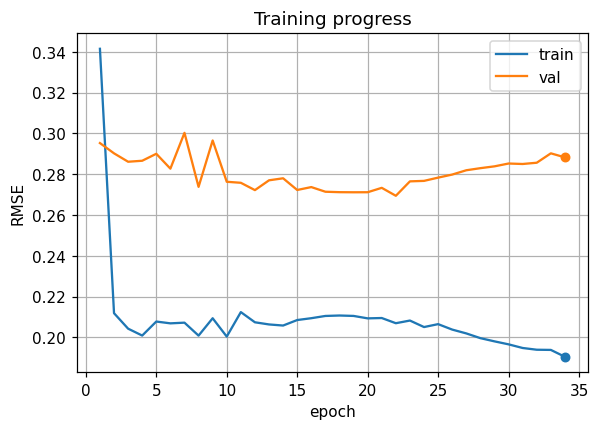

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3415 • val=0.2953 • lr=9.57e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2118 • val=0.2903 • lr=9.55e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2042 • val=0.2861 • lr=9.53e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2008 • val=0.2866 • lr=9.49e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2077 • val=0.2900 • lr=9.44e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2068 • val=0.2827 • lr=9.39e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2072 • val=0.3003 • lr=9.32e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2008 • val=0.2738 • lr=9.24e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2093 • val=0.2966 • lr=9.16e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2003 • val=0.2763 • lr=9.06e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2124 • val=0.2758 • lr=8.95e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2074 • val=0.2722 • lr=8.84e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2063 • val=0.2770 • lr=8.72e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2058 • val=0.2780 • lr=8.59e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2085 • val=0.2723 • lr=8.45e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2094 • val=0.2737 • lr=8.30e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2105 • val=0.2714 • lr=8.15e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2107 • val=0.2712 • lr=7.99e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2105 • val=0.2711 • lr=7.82e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2093 • val=0.2712 • lr=7.65e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2095 • val=0.2733 • lr=7.48e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2069 • val=0.2694 • lr=7.29e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2082 • val=0.2765 • lr=7.11e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2050 • val=0.2767 • lr=6.92e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2065 • val=0.2783 • lr=6.73e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2038 • val=0.2798 • lr=6.53e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2019 • val=0.2820 • lr=6.33e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1996 • val=0.2830 • lr=6.13e-04


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1980 • val=0.2839 • lr=5.93e-04


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1965 • val=0.2853 • lr=5.73e-04


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1947 • val=0.2850 • lr=5.53e-04


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.1939 • val=0.2856 • lr=5.33e-04


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.1938 • val=0.2903 • lr=5.13e-04


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1904 • val=0.2883 • lr=4.93e-04
Early stopping at epoch 34
Saved full model + hparams to dfs training/GOOGL_0.2694.pth


[I 2025-07-25 01:32:30,646] Trial 17 finished with value: 0.26942805091632793 and parameters: {'DROPOUT_SHORT': 0.2861747765766648, 'DROPOUT_LONG': 0.23374264963024943, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.23516316141933935, 'INITIAL_LR': 0.0009573269412491425, 'ETA_MIN': 0.0001881236880201239, 'WEIGHT_DECAY': 8.293066812154035e-05, 'CLIPNORM': 0.47551289554246257, 'LR_EPOCHS_WARMUP': 7}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 18 starting with:
{'DROPOUT_SHORT': 0.24585686638276505, 'DROPOUT_LONG': 0.23689321719011525, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.18202312787554298, 'INITIAL_LR': 0.026649831466692933, 'ETA_MIN': 0.00028632174689192155, 'WEIGHT_DECAY': 0.00023121277748317916, 'CLIPNORM': 0.7390285937725987, 'LR_EPOCHS_WARMUP': 10}



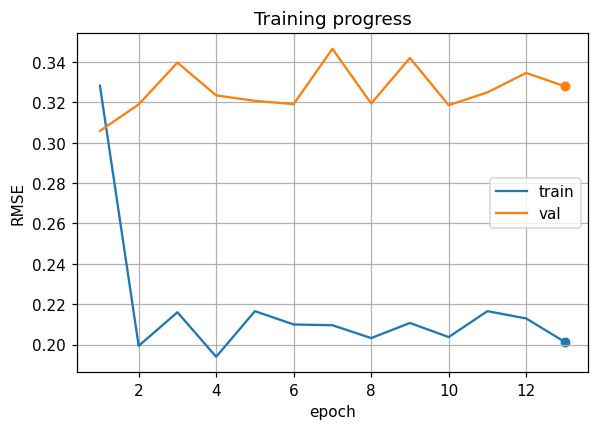

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3283 • val=0.3059 • lr=2.66e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1993 • val=0.3190 • lr=2.66e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2160 • val=0.3398 • lr=2.65e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1939 • val=0.3235 • lr=2.64e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2165 • val=0.3208 • lr=2.62e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2099 • val=0.3192 • lr=2.60e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2096 • val=0.3466 • lr=2.58e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2032 • val=0.3195 • lr=2.55e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2107 • val=0.3420 • lr=2.52e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2037 • val=0.3186 • lr=2.49e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2165 • val=0.3250 • lr=2.45e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2129 • val=0.3346 • lr=2.41e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2012 • val=0.3280 • lr=2.37e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3059.pth


[I 2025-07-25 01:41:51,354] Trial 18 finished with value: 0.30586982224130843 and parameters: {'DROPOUT_SHORT': 0.24585686638276505, 'DROPOUT_LONG': 0.23689321719011525, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.18202312787554298, 'INITIAL_LR': 0.026649831466692933, 'ETA_MIN': 0.00028632174689192155, 'WEIGHT_DECAY': 0.00023121277748317916, 'CLIPNORM': 0.7390285937725987, 'LR_EPOCHS_WARMUP': 10}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 19 starting with:
{'DROPOUT_SHORT': 0.31967409750254533, 'DROPOUT_LONG': 0.2919039183983121, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.35754205718755305, 'INITIAL_LR': 0.03799457289363958, 'ETA_MIN': 0.0003528054246802612, 'WEIGHT_DECAY': 0.00013326724470747963, 'CLIPNORM': 0.5434821565531536, 'LR_EPOCHS_WARMUP': 6}



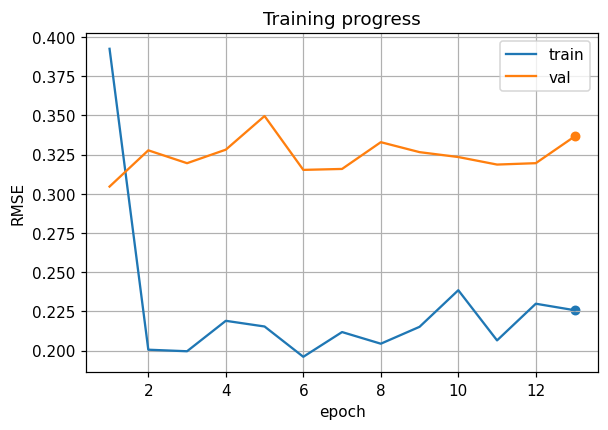

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3925 • val=0.3046 • lr=3.80e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2006 • val=0.3278 • lr=3.79e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1996 • val=0.3196 • lr=3.78e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2190 • val=0.3282 • lr=3.76e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2154 • val=0.3496 • lr=3.74e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1961 • val=0.3153 • lr=3.71e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2118 • val=0.3159 • lr=3.68e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2044 • val=0.3330 • lr=3.64e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2152 • val=0.3266 • lr=3.60e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2385 • val=0.3235 • lr=3.55e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2065 • val=0.3187 • lr=3.50e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2299 • val=0.3196 • lr=3.44e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2258 • val=0.3366 • lr=3.38e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3046.pth


[I 2025-07-25 01:48:08,067] Trial 19 finished with value: 0.30463704217353066 and parameters: {'DROPOUT_SHORT': 0.31967409750254533, 'DROPOUT_LONG': 0.2919039183983121, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.35754205718755305, 'INITIAL_LR': 0.03799457289363958, 'ETA_MIN': 0.0003528054246802612, 'WEIGHT_DECAY': 0.00013326724470747963, 'CLIPNORM': 0.5434821565531536, 'LR_EPOCHS_WARMUP': 6}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 20 starting with:
{'DROPOUT_SHORT': 0.3473666839474819, 'DROPOUT_LONG': 0.44747810823418854, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.31302725282860205, 'INITIAL_LR': 0.016942533043611048, 'ETA_MIN': 0.00018223163920283984, 'WEIGHT_DECAY': 6.032586562150325e-05, 'CLIPNORM': 0.6803214587901625, 'LR_EPOCHS_WARMUP': 10}



/workspace/my models/Trading/0.Stock Analysis/libs/plots.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)


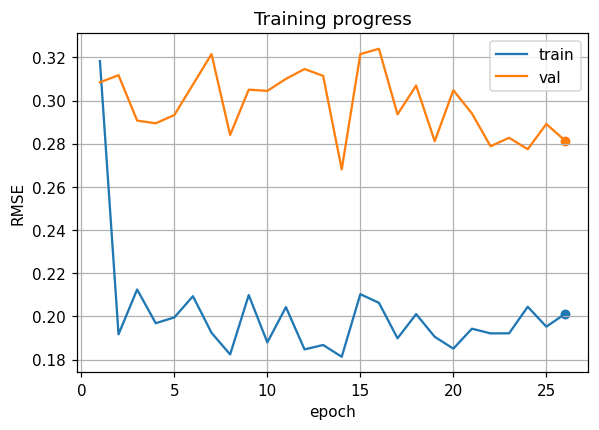

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3182 • val=0.3084 • lr=1.69e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1917 • val=0.3117 • lr=1.69e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2125 • val=0.2907 • lr=1.68e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1969 • val=0.2895 • lr=1.68e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1996 • val=0.2933 • lr=1.67e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2094 • val=0.3074 • lr=1.65e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1924 • val=0.3215 • lr=1.64e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1824 • val=0.2840 • lr=1.62e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2099 • val=0.3050 • lr=1.60e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1880 • val=0.3045 • lr=1.58e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2043 • val=0.3100 • lr=1.56e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1847 • val=0.3146 • lr=1.53e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1868 • val=0.3114 • lr=1.51e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1813 • val=0.2681 • lr=1.48e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2103 • val=0.3215 • lr=1.45e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2063 • val=0.3240 • lr=1.42e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1899 • val=0.2936 • lr=1.38e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2011 • val=0.3069 • lr=1.35e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1906 • val=0.2812 • lr=1.31e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1851 • val=0.3048 • lr=1.28e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1943 • val=0.2940 • lr=1.24e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1922 • val=0.2788 • lr=1.20e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1922 • val=0.2827 • lr=1.16e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2045 • val=0.2774 • lr=1.12e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1953 • val=0.2891 • lr=1.07e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2012 • val=0.2815 • lr=1.03e-02
Early stopping at epoch 26
Saved full model + hparams to dfs training/GOOGL_0.2681.pth


[I 2025-07-25 02:06:56,742] Trial 20 finished with value: 0.26811784614465234 and parameters: {'DROPOUT_SHORT': 0.3473666839474819, 'DROPOUT_LONG': 0.44747810823418854, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.31302725282860205, 'INITIAL_LR': 0.016942533043611048, 'ETA_MIN': 0.00018223163920283984, 'WEIGHT_DECAY': 6.032586562150325e-05, 'CLIPNORM': 0.6803214587901625, 'LR_EPOCHS_WARMUP': 10}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 21 starting with:
{'DROPOUT_SHORT': 0.21433435700153727, 'DROPOUT_LONG': 0.2651012756308372, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.29387627534536237, 'INITIAL_LR': 0.022332293947782054, 'ETA_MIN': 0.00041450163295375165, 'WEIGHT_DECAY': 0.0003945940948148227, 'CLIPNORM': 0.864204146169698, 'LR_EPOCHS_WARMUP': 7}



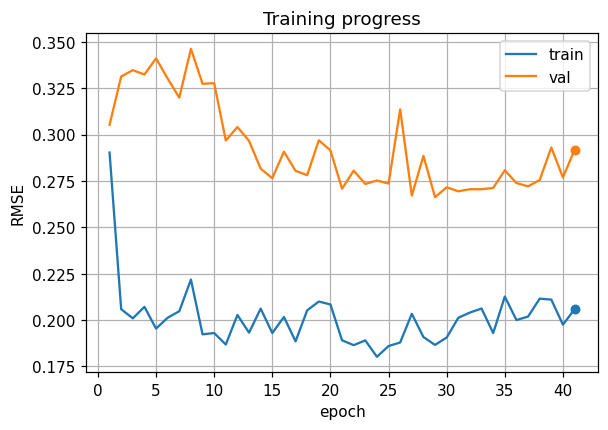

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2904 • val=0.3053 • lr=2.23e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2059 • val=0.3314 • lr=2.23e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2009 • val=0.3348 • lr=2.22e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2071 • val=0.3324 • lr=2.21e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1954 • val=0.3411 • lr=2.20e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2013 • val=0.3302 • lr=2.18e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2048 • val=0.3200 • lr=2.16e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2219 • val=0.3463 • lr=2.14e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1923 • val=0.3274 • lr=2.11e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1930 • val=0.3277 • lr=2.09e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1868 • val=0.2968 • lr=2.06e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2028 • val=0.3041 • lr=2.02e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1932 • val=0.2966 • lr=1.99e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2062 • val=0.2817 • lr=1.95e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1930 • val=0.2765 • lr=1.91e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2017 • val=0.2908 • lr=1.87e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1886 • val=0.2805 • lr=1.83e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2053 • val=0.2782 • lr=1.78e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2100 • val=0.2970 • lr=1.73e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2084 • val=0.2915 • lr=1.69e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1891 • val=0.2708 • lr=1.64e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1865 • val=0.2806 • lr=1.58e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1891 • val=0.2734 • lr=1.53e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1802 • val=0.2753 • lr=1.48e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1860 • val=0.2736 • lr=1.42e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1879 • val=0.3136 • lr=1.37e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2034 • val=0.2672 • lr=1.31e-02


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1909 • val=0.2886 • lr=1.25e-02


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1866 • val=0.2662 • lr=1.20e-02


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1906 • val=0.2716 • lr=1.14e-02


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2013 • val=0.2695 • lr=1.08e-02


Epoch 32:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 032 • train=0.2041 • val=0.2706 • lr=1.02e-02


Epoch 33:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 033 • train=0.2062 • val=0.2706 • lr=9.67e-03


Epoch 34:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 034 • train=0.1930 • val=0.2713 • lr=9.10e-03


Epoch 35:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 035 • train=0.2127 • val=0.2808 • lr=8.55e-03


Epoch 36:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 036 • train=0.2000 • val=0.2739 • lr=8.00e-03


Epoch 37:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 037 • train=0.2019 • val=0.2721 • lr=7.45e-03


Epoch 38:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 038 • train=0.2116 • val=0.2755 • lr=6.92e-03


Epoch 39:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 039 • train=0.2111 • val=0.2930 • lr=6.41e-03


Epoch 40:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 040 • train=0.1975 • val=0.2770 • lr=5.90e-03


Epoch 41:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 041 • train=0.2058 • val=0.2918 • lr=5.41e-03
Early stopping at epoch 41
Saved full model + hparams to dfs training/GOOGL_0.2662.pth


[I 2025-07-25 02:36:44,683] Trial 21 finished with value: 0.26624951154494947 and parameters: {'DROPOUT_SHORT': 0.21433435700153727, 'DROPOUT_LONG': 0.2651012756308372, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.29387627534536237, 'INITIAL_LR': 0.022332293947782054, 'ETA_MIN': 0.00041450163295375165, 'WEIGHT_DECAY': 0.0003945940948148227, 'CLIPNORM': 0.864204146169698, 'LR_EPOCHS_WARMUP': 7}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 22 starting with:
{'DROPOUT_SHORT': 0.2357516387101172, 'DROPOUT_LONG': 0.2679092134052518, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2407719373275806, 'INITIAL_LR': 0.01942219422046802, 'ETA_MIN': 0.00010698388692399962, 'WEIGHT_DECAY': 0.00029705959361408336, 'CLIPNORM': 0.8246772982796123, 'LR_EPOCHS_WARMUP': 8}



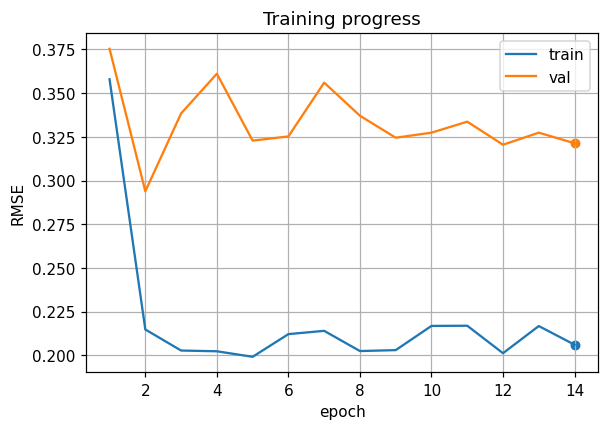

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3579 • val=0.3754 • lr=1.94e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2148 • val=0.2938 • lr=1.94e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2028 • val=0.3384 • lr=1.93e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2023 • val=0.3611 • lr=1.92e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1992 • val=0.3228 • lr=1.91e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2121 • val=0.3252 • lr=1.90e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2140 • val=0.3560 • lr=1.88e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2025 • val=0.3371 • lr=1.86e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2030 • val=0.3245 • lr=1.84e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2168 • val=0.3274 • lr=1.81e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2169 • val=0.3337 • lr=1.79e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2012 • val=0.3205 • lr=1.76e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2168 • val=0.3274 • lr=1.73e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2061 • val=0.3213 • lr=1.69e-02
Early stopping at epoch 14
Saved full model + hparams to dfs training/GOOGL_0.2938.pth


[I 2025-07-25 02:46:59,896] Trial 22 finished with value: 0.2938399107387288 and parameters: {'DROPOUT_SHORT': 0.2357516387101172, 'DROPOUT_LONG': 0.2679092134052518, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2407719373275806, 'INITIAL_LR': 0.01942219422046802, 'ETA_MIN': 0.00010698388692399962, 'WEIGHT_DECAY': 0.00029705959361408336, 'CLIPNORM': 0.8246772982796123, 'LR_EPOCHS_WARMUP': 8}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 23 starting with:
{'DROPOUT_SHORT': 0.26448113828195513, 'DROPOUT_LONG': 0.2892686636411443, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2885490455335241, 'INITIAL_LR': 0.02779480232884524, 'ETA_MIN': 0.00024020206036843666, 'WEIGHT_DECAY': 0.0004888341185628048, 'CLIPNORM': 0.929656830125118, 'LR_EPOCHS_WARMUP': 9}



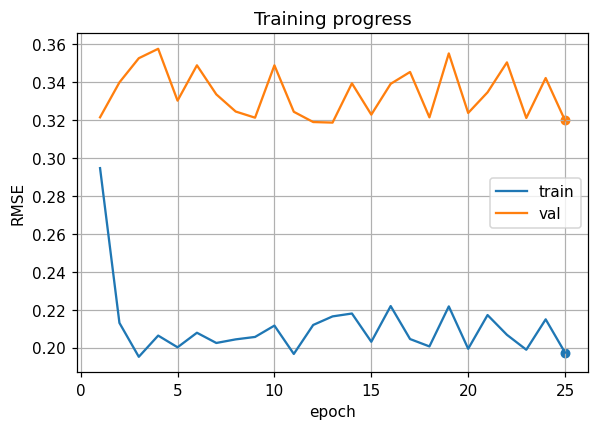

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2946 • val=0.3214 • lr=2.78e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2131 • val=0.3398 • lr=2.77e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1952 • val=0.3526 • lr=2.76e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2064 • val=0.3576 • lr=2.75e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2002 • val=0.3302 • lr=2.73e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2079 • val=0.3489 • lr=2.71e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2025 • val=0.3335 • lr=2.69e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2044 • val=0.3245 • lr=2.66e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2057 • val=0.3212 • lr=2.63e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2116 • val=0.3488 • lr=2.60e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1967 • val=0.3244 • lr=2.56e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2120 • val=0.3190 • lr=2.52e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2165 • val=0.3186 • lr=2.47e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2180 • val=0.3393 • lr=2.43e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2031 • val=0.3229 • lr=2.38e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2219 • val=0.3391 • lr=2.32e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2046 • val=0.3453 • lr=2.27e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2007 • val=0.3214 • lr=2.21e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2218 • val=0.3551 • lr=2.15e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1994 • val=0.3237 • lr=2.09e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2172 • val=0.3346 • lr=2.03e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2068 • val=0.3504 • lr=1.96e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1989 • val=0.3211 • lr=1.90e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2149 • val=0.3421 • lr=1.83e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1974 • val=0.3198 • lr=1.76e-02
Early stopping at epoch 25
Saved full model + hparams to dfs training/GOOGL_0.3186.pth


[I 2025-07-25 03:05:18,241] Trial 23 finished with value: 0.31864915989970044 and parameters: {'DROPOUT_SHORT': 0.26448113828195513, 'DROPOUT_LONG': 0.2892686636411443, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2885490455335241, 'INITIAL_LR': 0.02779480232884524, 'ETA_MIN': 0.00024020206036843666, 'WEIGHT_DECAY': 0.0004888341185628048, 'CLIPNORM': 0.929656830125118, 'LR_EPOCHS_WARMUP': 9}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 24 starting with:
{'DROPOUT_SHORT': 0.1721476288383685, 'DROPOUT_LONG': 0.3377389318844288, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.31770830264328614, 'INITIAL_LR': 0.011916239226553448, 'ETA_MIN': 0.0004987451739544731, 'WEIGHT_DECAY': 0.00018660562363671736, 'CLIPNORM': 0.7902745208929673, 'LR_EPOCHS_WARMUP': 9}



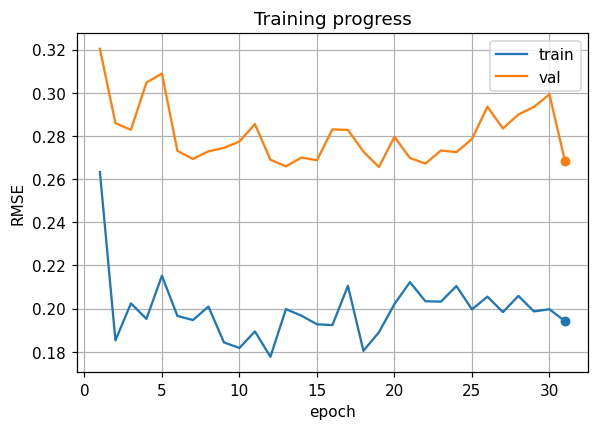

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2633 • val=0.3204 • lr=1.19e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1853 • val=0.2859 • lr=1.19e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2024 • val=0.2828 • lr=1.18e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1952 • val=0.3047 • lr=1.18e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2153 • val=0.3089 • lr=1.17e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1966 • val=0.2731 • lr=1.16e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1947 • val=0.2693 • lr=1.15e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2009 • val=0.2729 • lr=1.14e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1843 • val=0.2745 • lr=1.13e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1818 • val=0.2774 • lr=1.12e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1894 • val=0.2855 • lr=1.10e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1777 • val=0.2690 • lr=1.08e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1998 • val=0.2659 • lr=1.06e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1967 • val=0.2700 • lr=1.05e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1927 • val=0.2687 • lr=1.02e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1924 • val=0.2830 • lr=1.00e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2106 • val=0.2828 • lr=9.80e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1804 • val=0.2727 • lr=9.57e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1890 • val=0.2656 • lr=9.32e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2021 • val=0.2796 • lr=9.07e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2123 • val=0.2698 • lr=8.80e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2034 • val=0.2672 • lr=8.53e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2032 • val=0.2733 • lr=8.26e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2105 • val=0.2725 • lr=7.98e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1997 • val=0.2785 • lr=7.69e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2055 • val=0.2936 • lr=7.40e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1984 • val=0.2835 • lr=7.11e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2059 • val=0.2900 • lr=6.81e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.1987 • val=0.2934 • lr=6.51e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.1997 • val=0.2993 • lr=6.21e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.1942 • val=0.2684 • lr=5.91e-03
Early stopping at epoch 31
Saved full model + hparams to dfs training/GOOGL_0.2656.pth


[I 2025-07-25 03:28:05,836] Trial 24 finished with value: 0.2656217426556363 and parameters: {'DROPOUT_SHORT': 0.1721476288383685, 'DROPOUT_LONG': 0.3377389318844288, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.31770830264328614, 'INITIAL_LR': 0.011916239226553448, 'ETA_MIN': 0.0004987451739544731, 'WEIGHT_DECAY': 0.00018660562363671736, 'CLIPNORM': 0.7902745208929673, 'LR_EPOCHS_WARMUP': 9}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 25 starting with:
{'DROPOUT_SHORT': 0.29663170997749533, 'DROPOUT_LONG': 0.24413892649149851, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3669695529261003, 'INITIAL_LR': 0.03567821469852779, 'ETA_MIN': 0.00017900094267436547, 'WEIGHT_DECAY': 0.0003287889462640671, 'CLIPNORM': 0.682134539527949, 'LR_EPOCHS_WARMUP': 7}



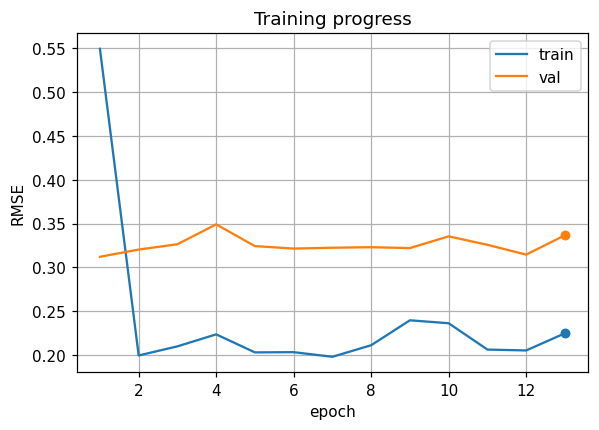

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.5492 • val=0.3122 • lr=3.57e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1997 • val=0.3204 • lr=3.56e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2101 • val=0.3265 • lr=3.55e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2238 • val=0.3491 • lr=3.53e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2032 • val=0.3243 • lr=3.51e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2035 • val=0.3215 • lr=3.48e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1982 • val=0.3225 • lr=3.45e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2114 • val=0.3231 • lr=3.41e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2398 • val=0.3221 • lr=3.38e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2364 • val=0.3355 • lr=3.33e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2064 • val=0.3258 • lr=3.28e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2054 • val=0.3146 • lr=3.23e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2250 • val=0.3367 • lr=3.17e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3122.pth


[I 2025-07-25 03:37:40,506] Trial 25 finished with value: 0.31216693483947366 and parameters: {'DROPOUT_SHORT': 0.29663170997749533, 'DROPOUT_LONG': 0.24413892649149851, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3669695529261003, 'INITIAL_LR': 0.03567821469852779, 'ETA_MIN': 0.00017900094267436547, 'WEIGHT_DECAY': 0.0003287889462640671, 'CLIPNORM': 0.682134539527949, 'LR_EPOCHS_WARMUP': 7}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 26 starting with:
{'DROPOUT_SHORT': 0.22108732542272472, 'DROPOUT_LONG': 0.2801505909734301, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3973695065550435, 'INITIAL_LR': 0.02377770126473693, 'ETA_MIN': 0.0003621778003371963, 'WEIGHT_DECAY': 0.00040966541750268106, 'CLIPNORM': 0.9010796947841515, 'LR_EPOCHS_WARMUP': 5}



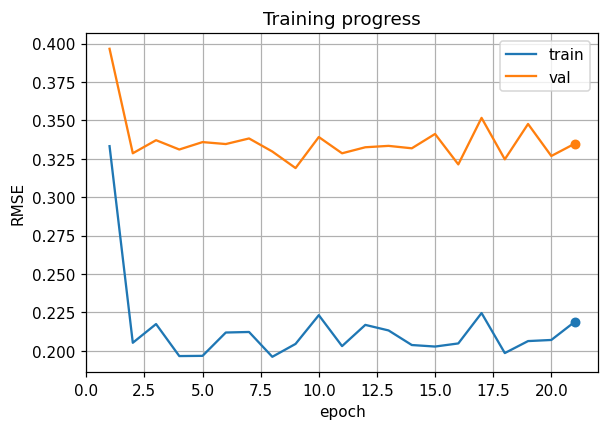

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3333 • val=0.3966 • lr=2.38e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2053 • val=0.3286 • lr=2.37e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2175 • val=0.3371 • lr=2.36e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1966 • val=0.3311 • lr=2.35e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1968 • val=0.3359 • lr=2.34e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2120 • val=0.3346 • lr=2.32e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2123 • val=0.3383 • lr=2.30e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1961 • val=0.3298 • lr=2.28e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2045 • val=0.3190 • lr=2.25e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2232 • val=0.3392 • lr=2.22e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2031 • val=0.3286 • lr=2.19e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2169 • val=0.3325 • lr=2.15e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2133 • val=0.3335 • lr=2.12e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2038 • val=0.3319 • lr=2.08e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2028 • val=0.3412 • lr=2.04e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2048 • val=0.3214 • lr=1.99e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2246 • val=0.3517 • lr=1.94e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1986 • val=0.3247 • lr=1.90e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2064 • val=0.3477 • lr=1.85e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2071 • val=0.3269 • lr=1.79e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2188 • val=0.3348 • lr=1.74e-02
Early stopping at epoch 21
Saved full model + hparams to dfs training/GOOGL_0.3190.pth


[I 2025-07-25 03:53:12,700] Trial 26 finished with value: 0.3190043645888027 and parameters: {'DROPOUT_SHORT': 0.22108732542272472, 'DROPOUT_LONG': 0.2801505909734301, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3973695065550435, 'INITIAL_LR': 0.02377770126473693, 'ETA_MIN': 0.0003621778003371963, 'WEIGHT_DECAY': 0.00040966541750268106, 'CLIPNORM': 0.9010796947841515, 'LR_EPOCHS_WARMUP': 5}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 27 starting with:
{'DROPOUT_SHORT': 0.255330234149463, 'DROPOUT_LONG': 0.3040932664675735, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.27334053347954135, 'INITIAL_LR': 0.01999696172518889, 'ETA_MIN': 5.658918002617968e-05, 'WEIGHT_DECAY': 0.0004448282698863308, 'CLIPNORM': 0.7768072454752812, 'LR_EPOCHS_WARMUP': 11}



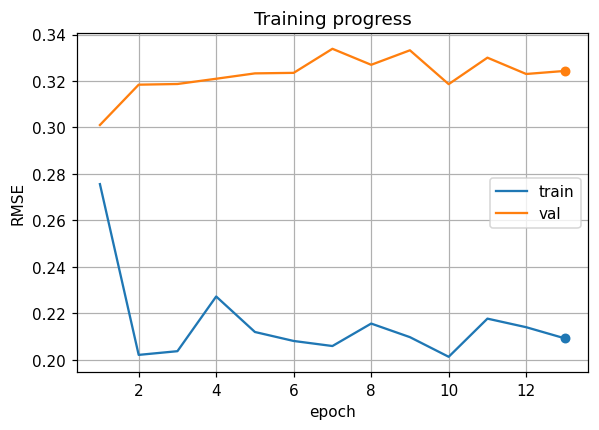

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2756 • val=0.3011 • lr=2.00e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2021 • val=0.3184 • lr=1.99e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2037 • val=0.3187 • lr=1.99e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2273 • val=0.3210 • lr=1.98e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2120 • val=0.3233 • lr=1.97e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2081 • val=0.3235 • lr=1.95e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2059 • val=0.3339 • lr=1.93e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2156 • val=0.3270 • lr=1.91e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2098 • val=0.3332 • lr=1.89e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2013 • val=0.3186 • lr=1.87e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2177 • val=0.3300 • lr=1.84e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2140 • val=0.3230 • lr=1.81e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2092 • val=0.3243 • lr=1.78e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3011.pth


[I 2025-07-25 04:02:51,303] Trial 27 finished with value: 0.30105835656507063 and parameters: {'DROPOUT_SHORT': 0.255330234149463, 'DROPOUT_LONG': 0.3040932664675735, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.27334053347954135, 'INITIAL_LR': 0.01999696172518889, 'ETA_MIN': 5.658918002617968e-05, 'WEIGHT_DECAY': 0.0004448282698863308, 'CLIPNORM': 0.7768072454752812, 'LR_EPOCHS_WARMUP': 11}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 28 starting with:
{'DROPOUT_SHORT': 0.28330976383755013, 'DROPOUT_LONG': 0.21919177999277187, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.22505792497408073, 'INITIAL_LR': 0.043885446474517587, 'ETA_MIN': 0.00025286336526778274, 'WEIGHT_DECAY': 0.00025627441292227246, 'CLIPNORM': 0.9846334532384489, 'LR_EPOCHS_WARMUP': 9}



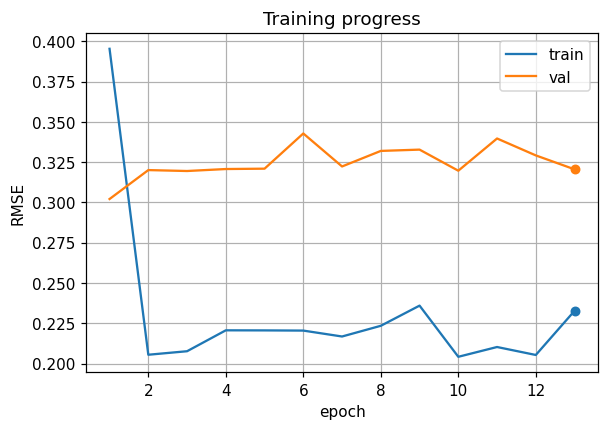

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3954 • val=0.3021 • lr=4.39e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2054 • val=0.3201 • lr=4.38e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2076 • val=0.3195 • lr=4.36e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2206 • val=0.3207 • lr=4.34e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2206 • val=0.3210 • lr=4.31e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2204 • val=0.3428 • lr=4.28e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2168 • val=0.3223 • lr=4.24e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2234 • val=0.3320 • lr=4.20e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2359 • val=0.3328 • lr=4.15e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2042 • val=0.3197 • lr=4.10e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2102 • val=0.3397 • lr=4.04e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2053 • val=0.3292 • lr=3.97e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2327 • val=0.3205 • lr=3.90e-02
Early stopping at epoch 13
Saved full model + hparams to dfs training/GOOGL_0.3021.pth


[I 2025-07-25 04:09:29,319] Trial 28 finished with value: 0.3021196099682453 and parameters: {'DROPOUT_SHORT': 0.28330976383755013, 'DROPOUT_LONG': 0.21919177999277187, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.22505792497408073, 'INITIAL_LR': 0.043885446474517587, 'ETA_MIN': 0.00025286336526778274, 'WEIGHT_DECAY': 0.00025627441292227246, 'CLIPNORM': 0.9846334532384489, 'LR_EPOCHS_WARMUP': 9}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 29 starting with:
{'DROPOUT_SHORT': 0.3178885334215852, 'DROPOUT_LONG': 0.33217638109047687, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.14763064960161273, 'INITIAL_LR': 0.028482910557603353, 'ETA_MIN': 0.0004232682544379349, 'WEIGHT_DECAY': 0.00015153095738502513, 'CLIPNORM': 0.8279747695278385, 'LR_EPOCHS_WARMUP': 3}



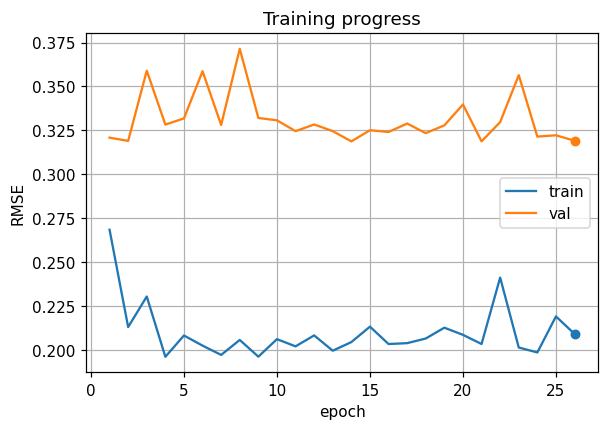

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2685 • val=0.3209 • lr=2.85e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2131 • val=0.3190 • lr=2.84e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2305 • val=0.3589 • lr=2.83e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1962 • val=0.3283 • lr=2.82e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2083 • val=0.3318 • lr=2.80e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2026 • val=0.3587 • lr=2.78e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1973 • val=0.3281 • lr=2.76e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2058 • val=0.3714 • lr=2.73e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1963 • val=0.3321 • lr=2.70e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2063 • val=0.3307 • lr=2.66e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2022 • val=0.3246 • lr=2.62e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2084 • val=0.3284 • lr=2.58e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1997 • val=0.3246 • lr=2.54e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2046 • val=0.3188 • lr=2.49e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2134 • val=0.3251 • lr=2.44e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2035 • val=0.3241 • lr=2.38e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2040 • val=0.3289 • lr=2.33e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2066 • val=0.3234 • lr=2.27e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2128 • val=0.3279 • lr=2.21e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2087 • val=0.3398 • lr=2.15e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2035 • val=0.3188 • lr=2.08e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2413 • val=0.3297 • lr=2.02e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2015 • val=0.3564 • lr=1.95e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1987 • val=0.3215 • lr=1.88e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2192 • val=0.3222 • lr=1.81e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.2092 • val=0.3191 • lr=1.74e-02
Early stopping at epoch 26
Saved full model + hparams to dfs training/GOOGL_0.3188.pth


[I 2025-07-25 04:24:55,819] Trial 29 finished with value: 0.31876645186443686 and parameters: {'DROPOUT_SHORT': 0.3178885334215852, 'DROPOUT_LONG': 0.33217638109047687, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.14763064960161273, 'INITIAL_LR': 0.028482910557603353, 'ETA_MIN': 0.0004232682544379349, 'WEIGHT_DECAY': 0.00015153095738502513, 'CLIPNORM': 0.8279747695278385, 'LR_EPOCHS_WARMUP': 3}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 30 starting with:
{'DROPOUT_SHORT': 0.3097698166334663, 'DROPOUT_LONG': 0.24946326452457718, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2500548710270968, 'INITIAL_LR': 0.03412008655642294, 'ETA_MIN': 0.00020739543863405258, 'WEIGHT_DECAY': 0.00048185999525754907, 'CLIPNORM': 0.3947473971064911, 'LR_EPOCHS_WARMUP': 8}



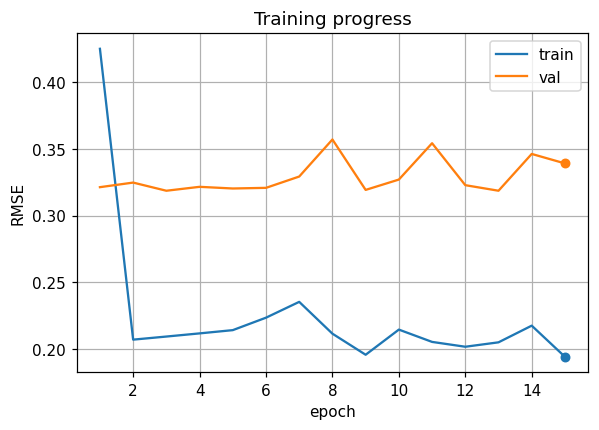

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4249 • val=0.3213 • lr=3.41e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2072 • val=0.3248 • lr=3.40e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2095 • val=0.3187 • lr=3.39e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2119 • val=0.3216 • lr=3.38e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2143 • val=0.3203 • lr=3.35e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2236 • val=0.3208 • lr=3.33e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2355 • val=0.3293 • lr=3.30e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2117 • val=0.3570 • lr=3.27e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1959 • val=0.3193 • lr=3.23e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2147 • val=0.3270 • lr=3.19e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2055 • val=0.3542 • lr=3.14e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2019 • val=0.3228 • lr=3.09e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2052 • val=0.3187 • lr=3.04e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2177 • val=0.3462 • lr=2.98e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1944 • val=0.3391 • lr=2.92e-02
Early stopping at epoch 15
Saved full model + hparams to dfs training/GOOGL_0.3187.pth


[I 2025-07-25 04:33:51,776] Trial 30 finished with value: 0.31865901684778736 and parameters: {'DROPOUT_SHORT': 0.3097698166334663, 'DROPOUT_LONG': 0.24946326452457718, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2500548710270968, 'INITIAL_LR': 0.03412008655642294, 'ETA_MIN': 0.00020739543863405258, 'WEIGHT_DECAY': 0.00048185999525754907, 'CLIPNORM': 0.3947473971064911, 'LR_EPOCHS_WARMUP': 8}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 31 starting with:
{'DROPOUT_SHORT': 0.33058847352084547, 'DROPOUT_LONG': 0.2567546096299378, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.32405823680002355, 'INITIAL_LR': 0.0008038517652004199, 'ETA_MIN': 3.477637356011739e-05, 'WEIGHT_DECAY': 0.0003694521307014043, 'CLIPNORM': 0.872885055376232, 'LR_EPOCHS_WARMUP': 11}



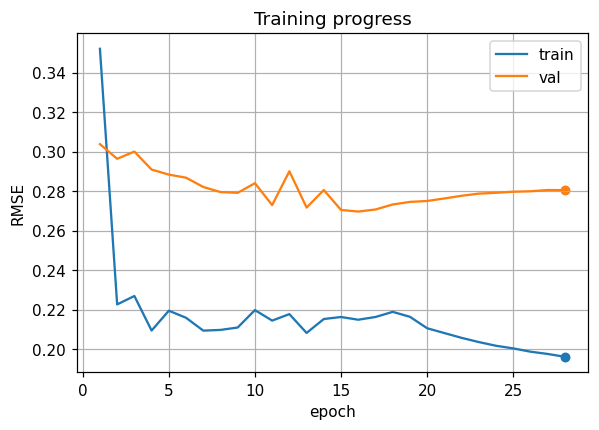

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3521 • val=0.3038 • lr=8.03e-04


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2226 • val=0.2964 • lr=8.02e-04


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2269 • val=0.3000 • lr=7.99e-04


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2094 • val=0.2909 • lr=7.96e-04


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2194 • val=0.2884 • lr=7.91e-04


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2158 • val=0.2868 • lr=7.85e-04


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2093 • val=0.2821 • lr=7.78e-04


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2097 • val=0.2795 • lr=7.71e-04


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2109 • val=0.2791 • lr=7.62e-04


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2197 • val=0.2840 • lr=7.52e-04


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2144 • val=0.2729 • lr=7.42e-04


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2177 • val=0.2901 • lr=7.31e-04


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2082 • val=0.2717 • lr=7.18e-04


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2152 • val=0.2806 • lr=7.05e-04


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2162 • val=0.2705 • lr=6.91e-04


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2149 • val=0.2697 • lr=6.77e-04


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2162 • val=0.2707 • lr=6.62e-04


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2188 • val=0.2732 • lr=6.46e-04


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.2163 • val=0.2745 • lr=6.29e-04


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2105 • val=0.2750 • lr=6.12e-04


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.2081 • val=0.2763 • lr=5.94e-04


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2057 • val=0.2776 • lr=5.76e-04


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2035 • val=0.2787 • lr=5.57e-04


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2017 • val=0.2792 • lr=5.38e-04


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2003 • val=0.2797 • lr=5.19e-04


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1987 • val=0.2799 • lr=5.00e-04


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1975 • val=0.2806 • lr=4.80e-04


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1961 • val=0.2805 • lr=4.60e-04
Early stopping at epoch 28
Saved full model + hparams to dfs training/GOOGL_0.2697.pth


[I 2025-07-25 04:50:36,991] Trial 31 finished with value: 0.26966147157975506 and parameters: {'DROPOUT_SHORT': 0.33058847352084547, 'DROPOUT_LONG': 0.2567546096299378, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.32405823680002355, 'INITIAL_LR': 0.0008038517652004199, 'ETA_MIN': 3.477637356011739e-05, 'WEIGHT_DECAY': 0.0003694521307014043, 'CLIPNORM': 0.872885055376232, 'LR_EPOCHS_WARMUP': 11}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 32 starting with:
{'DROPOUT_SHORT': 0.33153590851819315, 'DROPOUT_LONG': 0.3056306906135053, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3023994638575854, 'INITIAL_LR': 0.005662130935017979, 'ETA_MIN': 6.6293996729086e-05, 'WEIGHT_DECAY': 0.0003587356770812254, 'CLIPNORM': 0.852982853256948, 'LR_EPOCHS_WARMUP': 12}



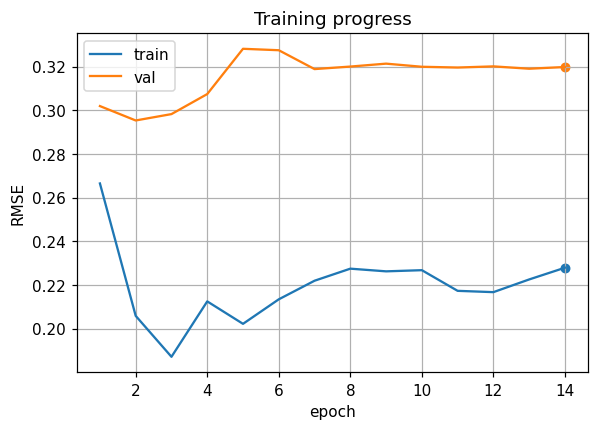

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2665 • val=0.3020 • lr=5.66e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2059 • val=0.2954 • lr=5.65e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1871 • val=0.2983 • lr=5.63e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2125 • val=0.3075 • lr=5.60e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2022 • val=0.3282 • lr=5.57e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2134 • val=0.3275 • lr=5.53e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2220 • val=0.3189 • lr=5.48e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2275 • val=0.3201 • lr=5.42e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2263 • val=0.3214 • lr=5.36e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2268 • val=0.3200 • lr=5.29e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2173 • val=0.3196 • lr=5.21e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2167 • val=0.3201 • lr=5.13e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2225 • val=0.3191 • lr=5.04e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2279 • val=0.3199 • lr=4.95e-03
Early stopping at epoch 14
Saved full model + hparams to dfs training/GOOGL_0.2954.pth


[I 2025-07-25 04:59:00,698] Trial 32 finished with value: 0.29536972279778556 and parameters: {'DROPOUT_SHORT': 0.33153590851819315, 'DROPOUT_LONG': 0.3056306906135053, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3023994638575854, 'INITIAL_LR': 0.005662130935017979, 'ETA_MIN': 6.6293996729086e-05, 'WEIGHT_DECAY': 0.0003587356770812254, 'CLIPNORM': 0.852982853256948, 'LR_EPOCHS_WARMUP': 12}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 33 starting with:
{'DROPOUT_SHORT': 0.2996092314766514, 'DROPOUT_LONG': 0.28258428964019017, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.18158422959712467, 'INITIAL_LR': 0.005600309079326574, 'ETA_MIN': 0.0001463083128301132, 'WEIGHT_DECAY': 0.0004699343863180836, 'CLIPNORM': 0.698947951505922, 'LR_EPOCHS_WARMUP': 10}



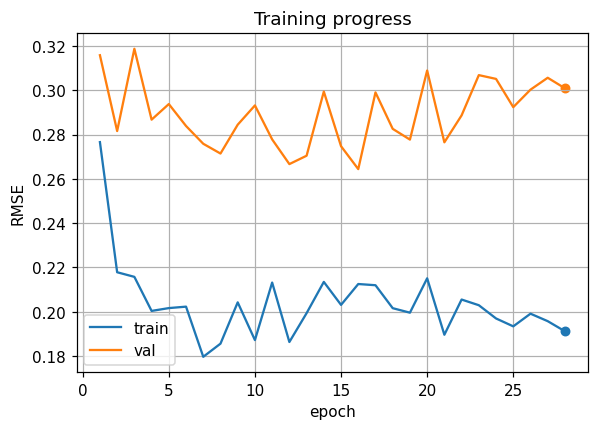

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2766 • val=0.3158 • lr=5.60e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2178 • val=0.2816 • lr=5.59e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2158 • val=0.3187 • lr=5.57e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2004 • val=0.2867 • lr=5.54e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2017 • val=0.2938 • lr=5.51e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2023 • val=0.2839 • lr=5.47e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1797 • val=0.2758 • lr=5.42e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1856 • val=0.2714 • lr=5.37e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2043 • val=0.2844 • lr=5.30e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1872 • val=0.2931 • lr=5.24e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2132 • val=0.2778 • lr=5.16e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1864 • val=0.2667 • lr=5.08e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1994 • val=0.2704 • lr=4.99e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2135 • val=0.2994 • lr=4.90e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2031 • val=0.2747 • lr=4.80e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2125 • val=0.2644 • lr=4.70e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2120 • val=0.2990 • lr=4.59e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2016 • val=0.2826 • lr=4.48e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1996 • val=0.2777 • lr=4.36e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2151 • val=0.3089 • lr=4.24e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1896 • val=0.2765 • lr=4.11e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2055 • val=0.2887 • lr=3.98e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.2030 • val=0.3068 • lr=3.85e-03


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.1970 • val=0.3051 • lr=3.72e-03


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.1934 • val=0.2924 • lr=3.58e-03


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1991 • val=0.3003 • lr=3.44e-03


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.1958 • val=0.3056 • lr=3.30e-03


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.1912 • val=0.3009 • lr=3.16e-03
Early stopping at epoch 28
Saved full model + hparams to dfs training/GOOGL_0.2644.pth


[I 2025-07-25 05:15:56,513] Trial 33 finished with value: 0.264399618388119 and parameters: {'DROPOUT_SHORT': 0.2996092314766514, 'DROPOUT_LONG': 0.28258428964019017, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.18158422959712467, 'INITIAL_LR': 0.005600309079326574, 'ETA_MIN': 0.0001463083128301132, 'WEIGHT_DECAY': 0.0004699343863180836, 'CLIPNORM': 0.698947951505922, 'LR_EPOCHS_WARMUP': 10}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 34 starting with:
{'DROPOUT_SHORT': 0.19879700047879661, 'DROPOUT_LONG': 0.31507294356518656, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3418037676057397, 'INITIAL_LR': 0.011603437914701555, 'ETA_MIN': 0.00011393394756261052, 'WEIGHT_DECAY': 0.00027899798255279527, 'CLIPNORM': 0.6298874416430489, 'LR_EPOCHS_WARMUP': 11}



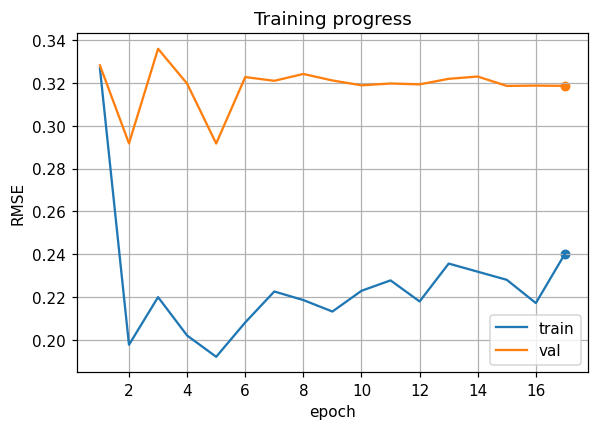

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3269 • val=0.3282 • lr=1.16e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1977 • val=0.2918 • lr=1.16e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2199 • val=0.3360 • lr=1.15e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2020 • val=0.3197 • lr=1.15e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1920 • val=0.2917 • lr=1.14e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2081 • val=0.3228 • lr=1.13e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2226 • val=0.3210 • lr=1.12e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2186 • val=0.3242 • lr=1.11e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2132 • val=0.3212 • lr=1.10e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2229 • val=0.3189 • lr=1.08e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2278 • val=0.3198 • lr=1.07e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2179 • val=0.3194 • lr=1.05e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2356 • val=0.3220 • lr=1.03e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2318 • val=0.3230 • lr=1.01e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2280 • val=0.3186 • lr=9.92e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.2172 • val=0.3188 • lr=9.71e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.2402 • val=0.3187 • lr=9.48e-03
Early stopping at epoch 17
Saved full model + hparams to dfs training/GOOGL_0.2917.pth


[I 2025-07-25 05:26:13,872] Trial 34 finished with value: 0.29171755167170893 and parameters: {'DROPOUT_SHORT': 0.19879700047879661, 'DROPOUT_LONG': 0.31507294356518656, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3418037676057397, 'INITIAL_LR': 0.011603437914701555, 'ETA_MIN': 0.00011393394756261052, 'WEIGHT_DECAY': 0.00027899798255279527, 'CLIPNORM': 0.6298874416430489, 'LR_EPOCHS_WARMUP': 11}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 35 starting with:
{'DROPOUT_SHORT': 0.2701987826888711, 'DROPOUT_LONG': 0.2747555983585564, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.20311998480593263, 'INITIAL_LR': 0.026036688704014165, 'ETA_MIN': 1.6668132814774485e-05, 'WEIGHT_DECAY': 0.0003400341601229029, 'CLIPNORM': 0.9301208850985659, 'LR_EPOCHS_WARMUP': 7}



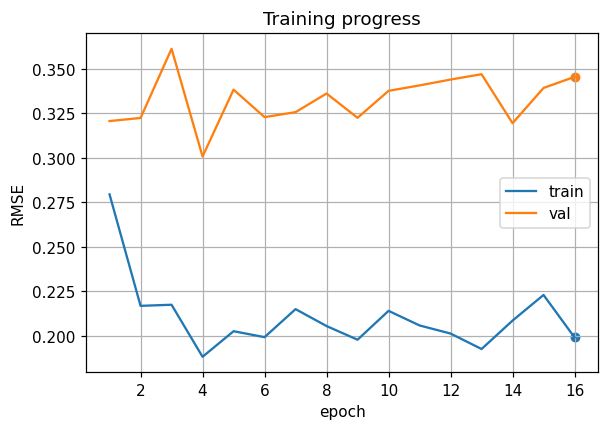

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2795 • val=0.3207 • lr=2.60e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2169 • val=0.3224 • lr=2.60e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2175 • val=0.3613 • lr=2.59e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1883 • val=0.3008 • lr=2.58e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2027 • val=0.3383 • lr=2.56e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1994 • val=0.3229 • lr=2.54e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2151 • val=0.3257 • lr=2.52e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2056 • val=0.3362 • lr=2.49e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1979 • val=0.3225 • lr=2.46e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2141 • val=0.3377 • lr=2.43e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2059 • val=0.3407 • lr=2.39e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2014 • val=0.3440 • lr=2.36e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1927 • val=0.3470 • lr=2.31e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2087 • val=0.3195 • lr=2.27e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.2231 • val=0.3393 • lr=2.22e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1992 • val=0.3455 • lr=2.17e-02
Early stopping at epoch 16
Saved full model + hparams to dfs training/GOOGL_0.3008.pth


[I 2025-07-25 05:36:04,809] Trial 35 finished with value: 0.3008033756053216 and parameters: {'DROPOUT_SHORT': 0.2701987826888711, 'DROPOUT_LONG': 0.2747555983585564, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.20311998480593263, 'INITIAL_LR': 0.026036688704014165, 'ETA_MIN': 1.6668132814774485e-05, 'WEIGHT_DECAY': 0.0003400341601229029, 'CLIPNORM': 0.9301208850985659, 'LR_EPOCHS_WARMUP': 7}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 36 starting with:
{'DROPOUT_SHORT': 0.32960218097688254, 'DROPOUT_LONG': 0.22376455985562727, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.2737206682517185, 'INITIAL_LR': 0.008489609817133068, 'ETA_MIN': 0.00046286053816746334, 'WEIGHT_DECAY': 5.2469515693663094e-06, 'CLIPNORM': 0.7788030776157981, 'LR_EPOCHS_WARMUP': 8}



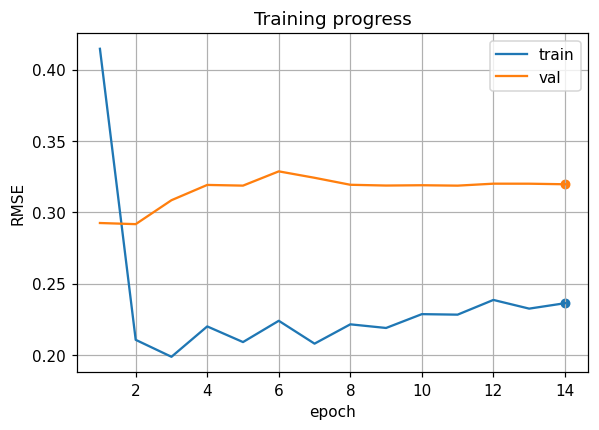

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.4146 • val=0.2924 • lr=8.48e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2106 • val=0.2916 • lr=8.47e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1987 • val=0.3084 • lr=8.44e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2200 • val=0.3191 • lr=8.40e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.2090 • val=0.3187 • lr=8.35e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2239 • val=0.3287 • lr=8.29e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2079 • val=0.3241 • lr=8.22e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2214 • val=0.3193 • lr=8.14e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2189 • val=0.3187 • lr=8.05e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.2286 • val=0.3189 • lr=7.95e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2282 • val=0.3186 • lr=7.84e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2385 • val=0.3200 • lr=7.73e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2324 • val=0.3200 • lr=7.60e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2362 • val=0.3196 • lr=7.46e-03
Early stopping at epoch 14
Saved full model + hparams to dfs training/GOOGL_0.2916.pth


[I 2025-07-25 05:43:29,564] Trial 36 finished with value: 0.2916480610903687 and parameters: {'DROPOUT_SHORT': 0.32960218097688254, 'DROPOUT_LONG': 0.22376455985562727, 'ATT_HEADS': 2, 'ATT_DROPOUT': 0.2737206682517185, 'INITIAL_LR': 0.008489609817133068, 'ETA_MIN': 0.00046286053816746334, 'WEIGHT_DECAY': 5.2469515693663094e-06, 'CLIPNORM': 0.7788030776157981, 'LR_EPOCHS_WARMUP': 8}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 37 starting with:
{'DROPOUT_SHORT': 0.23133290104050794, 'DROPOUT_LONG': 0.2536252839535281, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3086099576044689, 'INITIAL_LR': 0.01755814320962946, 'ETA_MIN': 0.0001610802345482965, 'WEIGHT_DECAY': 0.00045013559662238474, 'CLIPNORM': 0.8831993861024277, 'LR_EPOCHS_WARMUP': 10}



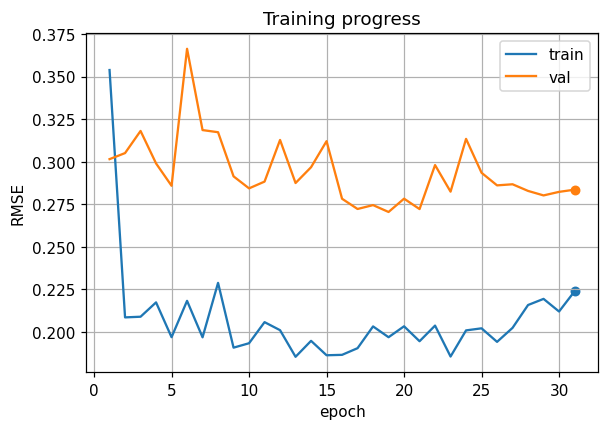

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3539 • val=0.3016 • lr=1.75e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.2086 • val=0.3051 • lr=1.75e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2090 • val=0.3181 • lr=1.75e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.2174 • val=0.2991 • lr=1.74e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1970 • val=0.2859 • lr=1.73e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2183 • val=0.3664 • lr=1.71e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1969 • val=0.3186 • lr=1.70e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2289 • val=0.3174 • lr=1.68e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1908 • val=0.2914 • lr=1.66e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1934 • val=0.2844 • lr=1.64e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2058 • val=0.2884 • lr=1.62e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.2011 • val=0.3128 • lr=1.59e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.1854 • val=0.2875 • lr=1.56e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1948 • val=0.2968 • lr=1.53e-02


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1863 • val=0.3121 • lr=1.50e-02


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1866 • val=0.2783 • lr=1.47e-02


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1905 • val=0.2723 • lr=1.43e-02


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.2033 • val=0.2746 • lr=1.40e-02


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1969 • val=0.2705 • lr=1.36e-02


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.2034 • val=0.2783 • lr=1.32e-02


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1946 • val=0.2722 • lr=1.28e-02


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.2038 • val=0.2981 • lr=1.24e-02


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 023 • train=0.1856 • val=0.2825 • lr=1.20e-02


Epoch 24:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 024 • train=0.2009 • val=0.3135 • lr=1.16e-02


Epoch 25:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 025 • train=0.2022 • val=0.2936 • lr=1.11e-02


Epoch 26:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 026 • train=0.1942 • val=0.2862 • lr=1.07e-02


Epoch 27:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 027 • train=0.2024 • val=0.2868 • lr=1.02e-02


Epoch 28:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 028 • train=0.2159 • val=0.2829 • lr=9.78e-03


Epoch 29:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 029 • train=0.2195 • val=0.2803 • lr=9.32e-03


Epoch 30:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 030 • train=0.2120 • val=0.2823 • lr=8.87e-03


Epoch 31:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 031 • train=0.2239 • val=0.2836 • lr=8.41e-03
Early stopping at epoch 31
Saved full model + hparams to dfs training/GOOGL_0.2705.pth


[I 2025-07-25 06:02:34,322] Trial 37 finished with value: 0.27052440710747977 and parameters: {'DROPOUT_SHORT': 0.23133290104050794, 'DROPOUT_LONG': 0.2536252839535281, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.3086099576044689, 'INITIAL_LR': 0.01755814320962946, 'ETA_MIN': 0.0001610802345482965, 'WEIGHT_DECAY': 0.00045013559662238474, 'CLIPNORM': 0.8831993861024277, 'LR_EPOCHS_WARMUP': 10}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 38 starting with:
{'DROPOUT_SHORT': 0.2533892671754646, 'DROPOUT_LONG': 0.21447719325469794, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2555288042098767, 'INITIAL_LR': 0.022357063176282187, 'ETA_MIN': 8.790534972423706e-05, 'WEIGHT_DECAY': 0.00038693398121932476, 'CLIPNORM': 0.8122027566873194, 'LR_EPOCHS_WARMUP': 0}



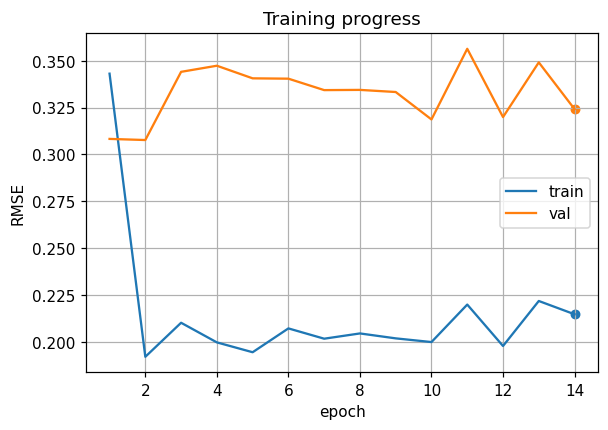

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.3431 • val=0.3083 • lr=2.23e-02


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1921 • val=0.3077 • lr=2.23e-02


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.2102 • val=0.3441 • lr=2.22e-02


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1997 • val=0.3473 • lr=2.21e-02


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1945 • val=0.3406 • lr=2.20e-02


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.2072 • val=0.3404 • lr=2.18e-02


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.2017 • val=0.3343 • lr=2.16e-02


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.2045 • val=0.3344 • lr=2.14e-02


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.2019 • val=0.3333 • lr=2.11e-02


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1999 • val=0.3187 • lr=2.09e-02


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.2199 • val=0.3564 • lr=2.06e-02


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1978 • val=0.3199 • lr=2.02e-02


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2218 • val=0.3491 • lr=1.99e-02


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.2147 • val=0.3242 • lr=1.95e-02
Early stopping at epoch 14
Saved full model + hparams to dfs training/GOOGL_0.3077.pth


[I 2025-07-25 06:13:16,298] Trial 38 finished with value: 0.30769866248210054 and parameters: {'DROPOUT_SHORT': 0.2533892671754646, 'DROPOUT_LONG': 0.21447719325469794, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.2555288042098767, 'INITIAL_LR': 0.022357063176282187, 'ETA_MIN': 8.790534972423706e-05, 'WEIGHT_DECAY': 0.00038693398121932476, 'CLIPNORM': 0.8122027566873194, 'LR_EPOCHS_WARMUP': 0}. Best is trial 7 with value: 0.2558724852856882.



▶ Trial 39 starting with:
{'DROPOUT_SHORT': 0.2078460012345474, 'DROPOUT_LONG': 0.3000268504696092, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3533458273001334, 'INITIAL_LR': 0.0031984536935834324, 'ETA_MIN': 0.0001365277100072243, 'WEIGHT_DECAY': 5.145837278832646e-05, 'CLIPNORM': 0.6301661085178587, 'LR_EPOCHS_WARMUP': 5}



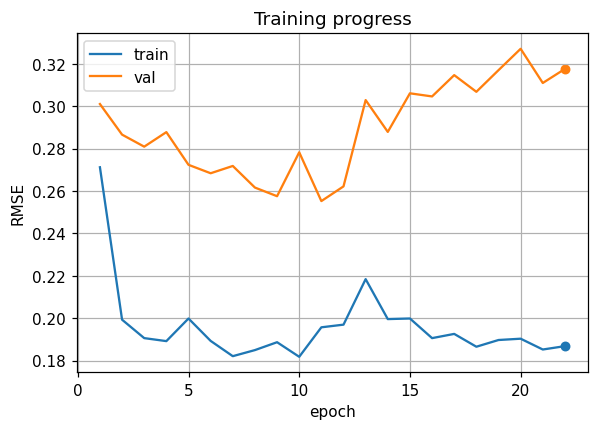

Epoch 1:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 001 • train=0.2712 • val=0.3010 • lr=3.20e-03


Epoch 2:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 002 • train=0.1993 • val=0.2866 • lr=3.19e-03


Epoch 3:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 003 • train=0.1906 • val=0.2809 • lr=3.18e-03


Epoch 4:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 004 • train=0.1892 • val=0.2878 • lr=3.17e-03


Epoch 5:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 005 • train=0.1998 • val=0.2723 • lr=3.15e-03


Epoch 6:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 006 • train=0.1893 • val=0.2683 • lr=3.12e-03


Epoch 7:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 007 • train=0.1821 • val=0.2718 • lr=3.10e-03


Epoch 8:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 008 • train=0.1849 • val=0.2616 • lr=3.07e-03


Epoch 9:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 009 • train=0.1886 • val=0.2575 • lr=3.03e-03


Epoch 10:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 010 • train=0.1818 • val=0.2782 • lr=2.99e-03


Epoch 11:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 011 • train=0.1957 • val=0.2552 • lr=2.95e-03


Epoch 12:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 012 • train=0.1969 • val=0.2622 • lr=2.91e-03


Epoch 13:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 013 • train=0.2184 • val=0.3029 • lr=2.86e-03


Epoch 14:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 014 • train=0.1996 • val=0.2879 • lr=2.81e-03


Epoch 15:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 015 • train=0.1998 • val=0.3061 • lr=2.75e-03


Epoch 16:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 016 • train=0.1906 • val=0.3046 • lr=2.69e-03


Epoch 17:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 017 • train=0.1926 • val=0.3146 • lr=2.63e-03


Epoch 18:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 018 • train=0.1865 • val=0.3068 • lr=2.57e-03


Epoch 19:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 019 • train=0.1897 • val=0.3170 • lr=2.50e-03


Epoch 20:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 020 • train=0.1903 • val=0.3271 • lr=2.43e-03


Epoch 21:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 021 • train=0.1852 • val=0.3109 • lr=2.36e-03


Epoch 22:   0%|          | 0/62 [00:00<?, ?bundle/s]

Epoch 022 • train=0.1868 • val=0.3176 • lr=2.29e-03


Epoch 23:   0%|          | 0/62 [00:00<?, ?bundle/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x74f2ba53fec0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
[W 2025-07-25 06:30:52,205] Trial 39 failed with parameters: {'DROPOUT_SHORT': 0.2078460012345474, 'DROPOUT_LONG': 0.3000268504696092, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3533458273001334, 'INITIAL_LR': 0.0031984536935834324, 'ETA_MIN': 0.0001365277100072243, 'WEIGHT_DECAY': 5.145837278832646e-05, 'CLIPNORM': 0.6301661085178587, 'LR_EPOCHS_WARMUP': 5} because of the following error: RuntimeError('DataLoader worker (pid(s) 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894) exited unexpectedly').
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1256, in _try_get_data
    da

RuntimeError: DataLoader worker (pid(s) 32887, 32888, 32889, 32890, 32891, 32892, 32893, 32894) exited unexpectedly

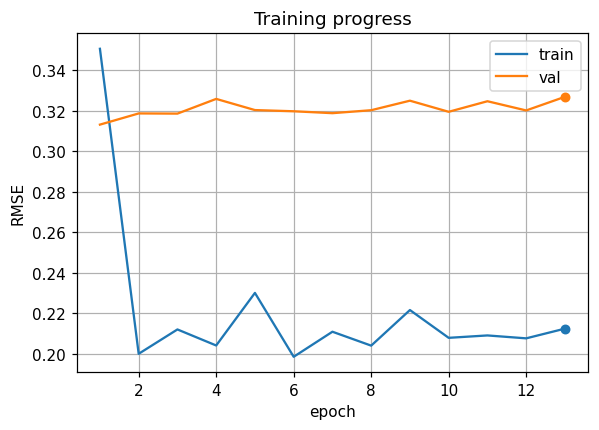

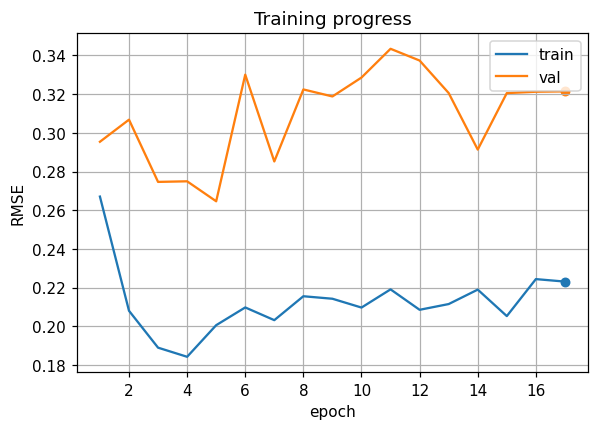

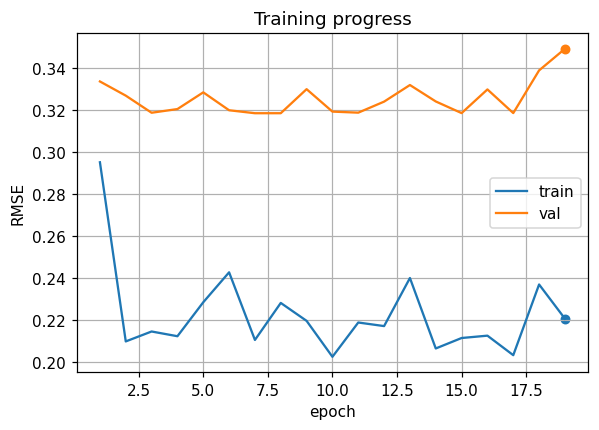

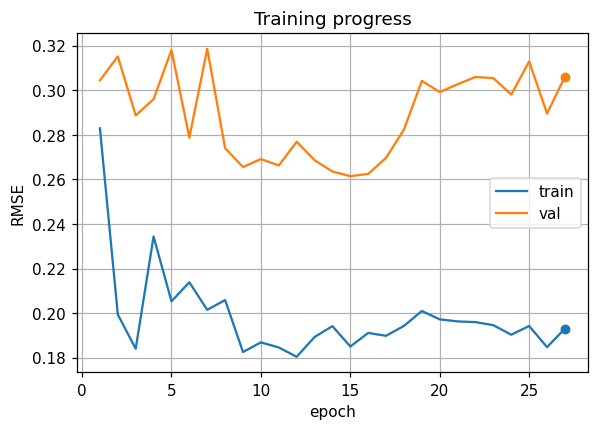

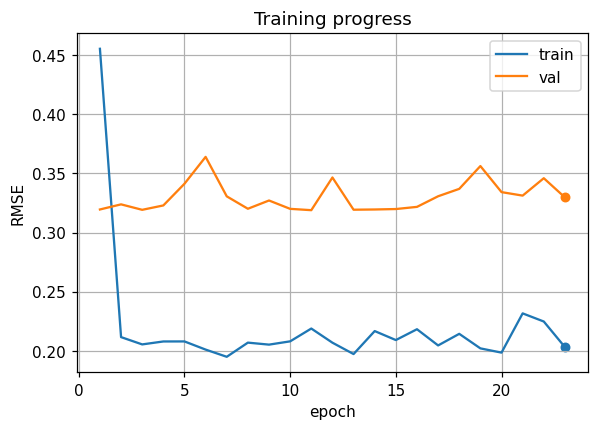

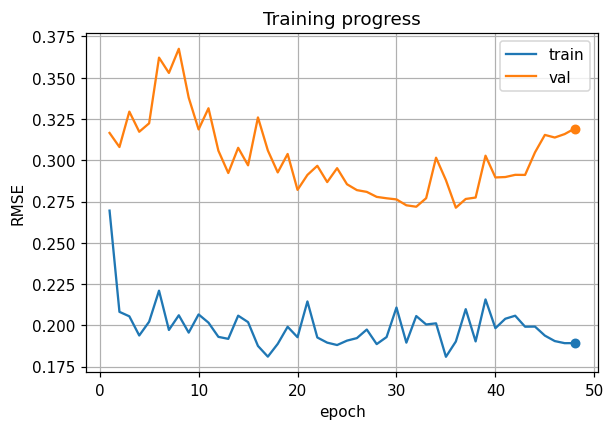

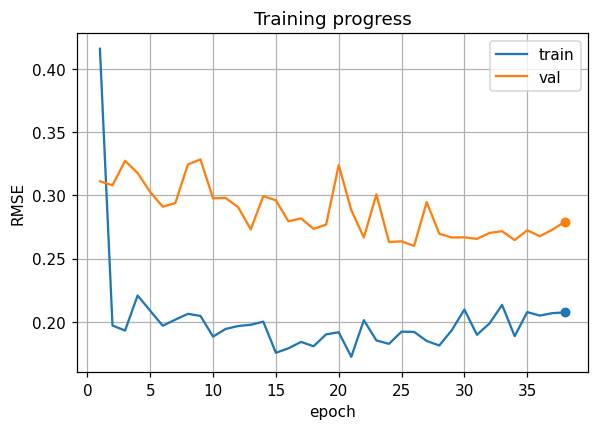

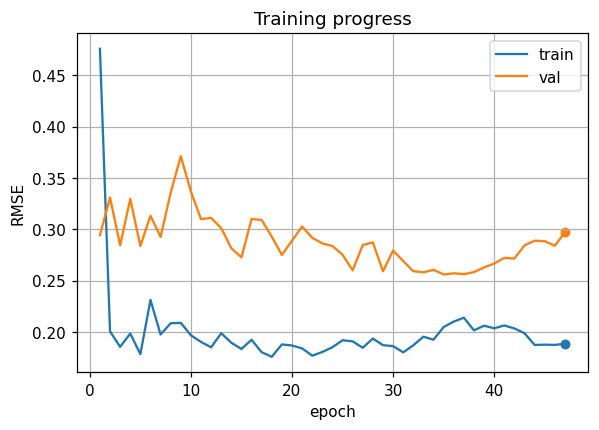

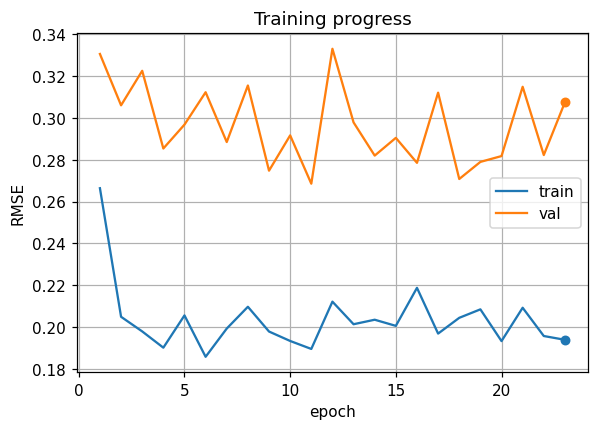

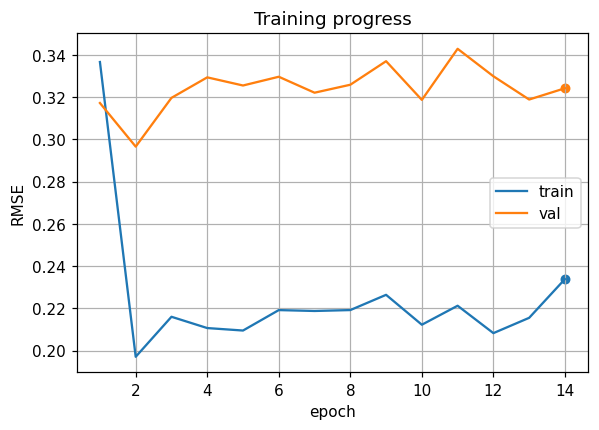

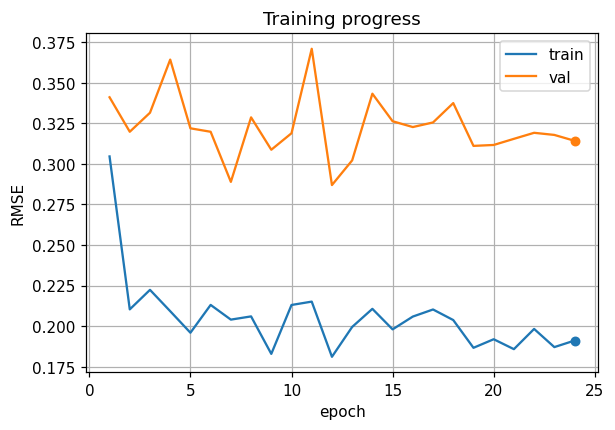

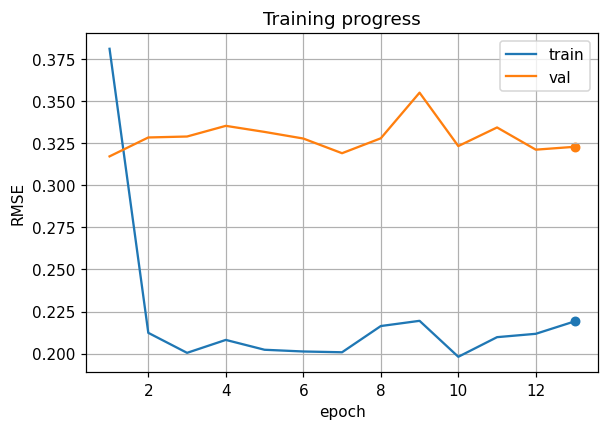

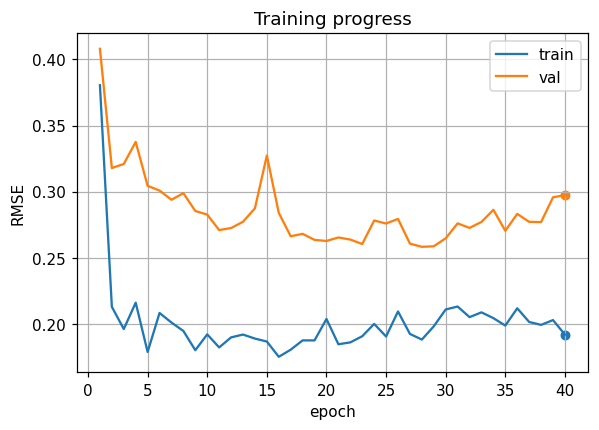

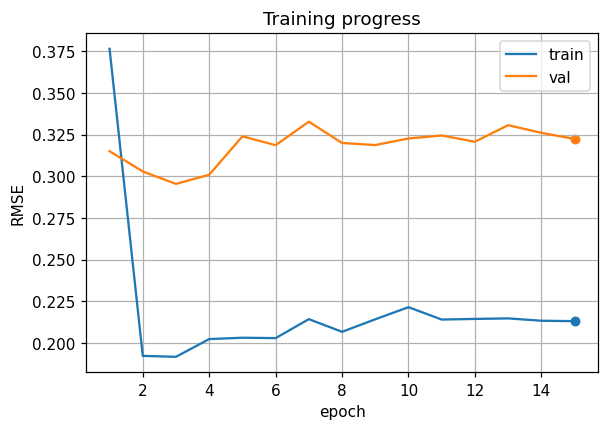

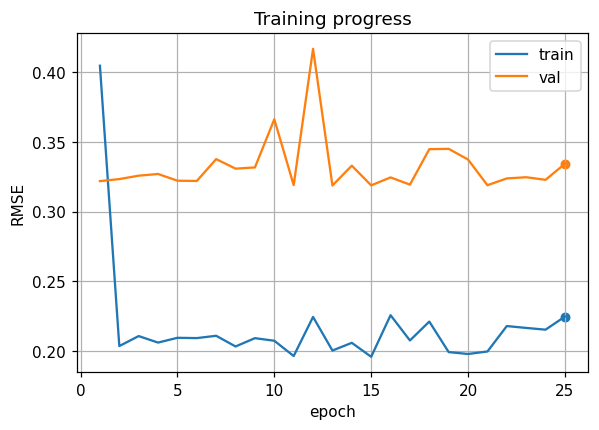

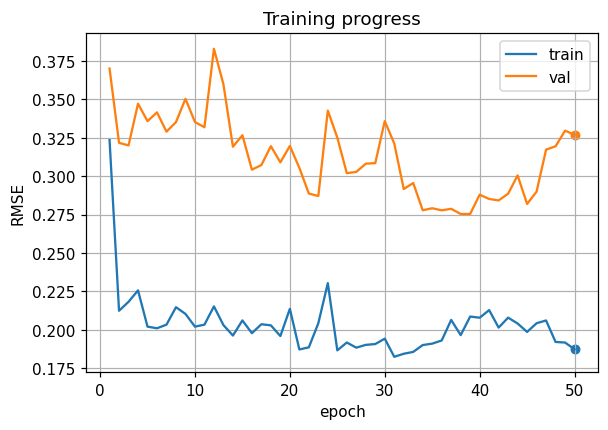

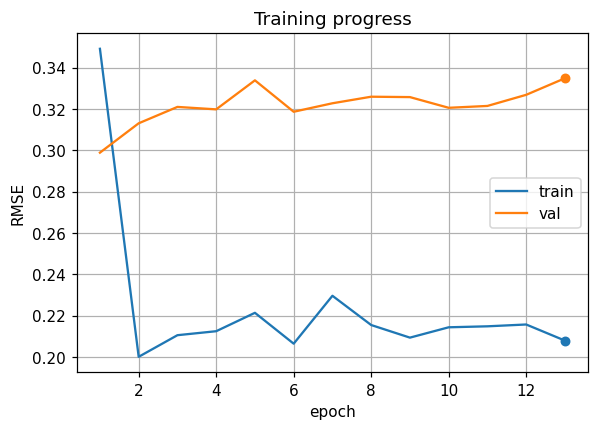

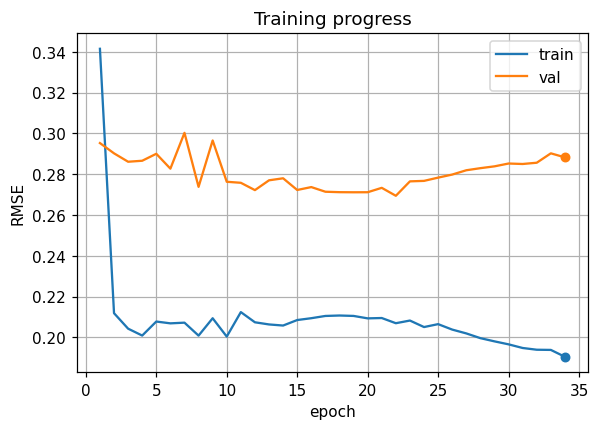

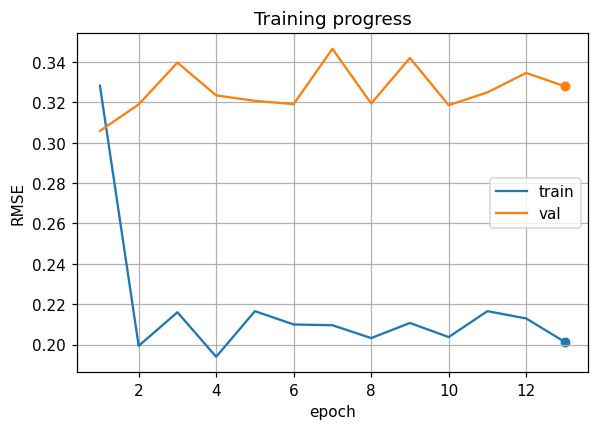

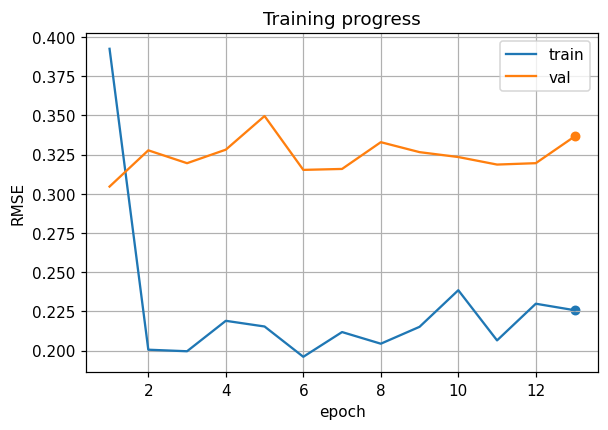

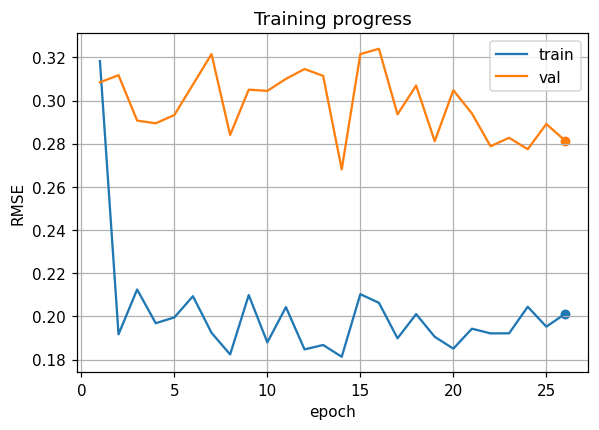

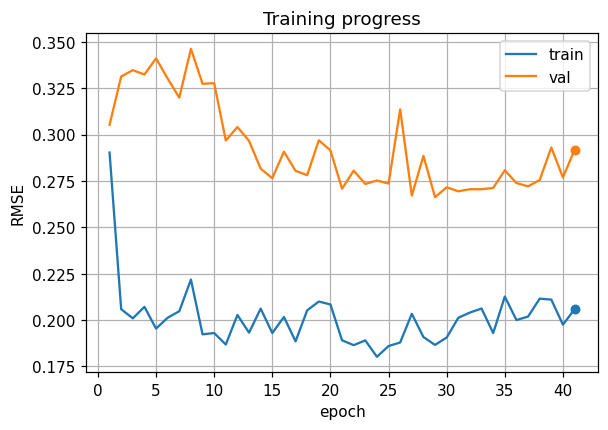

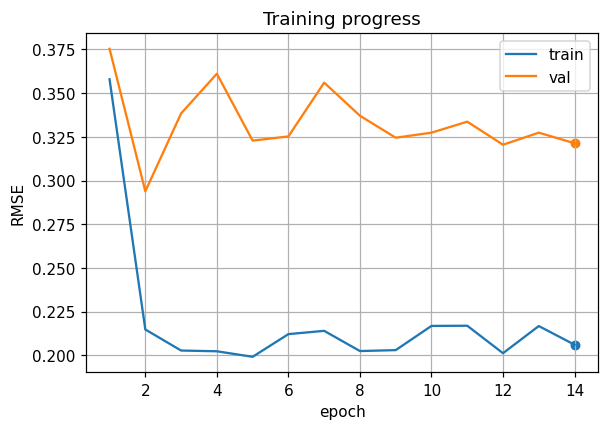

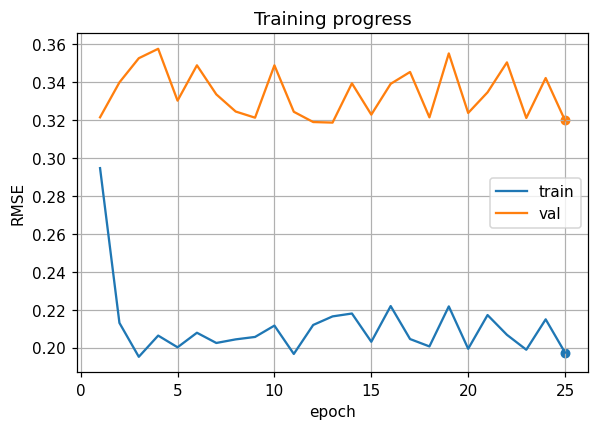

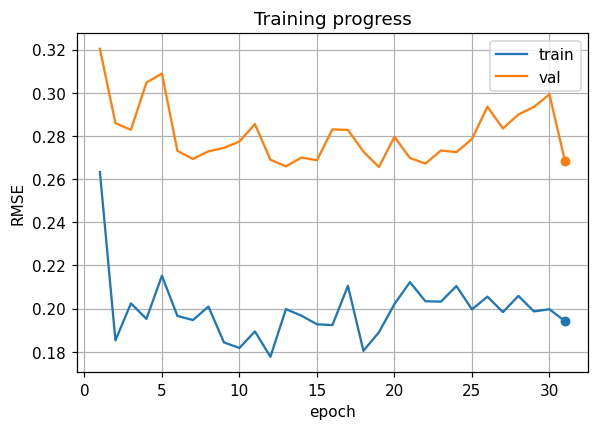

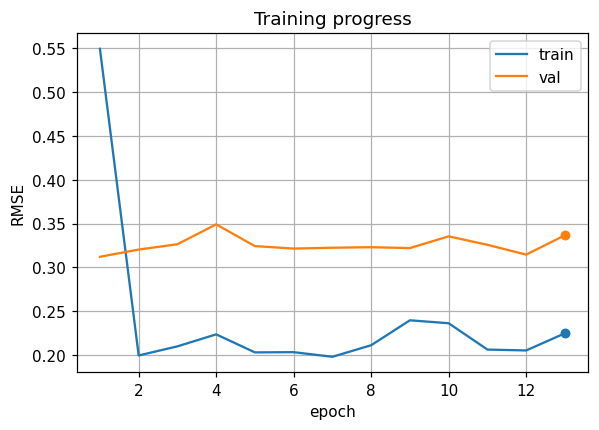

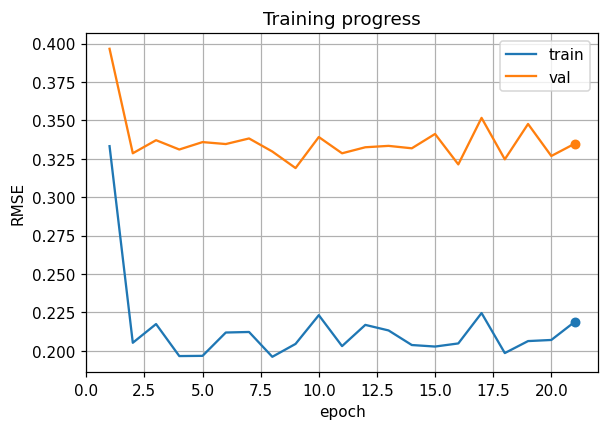

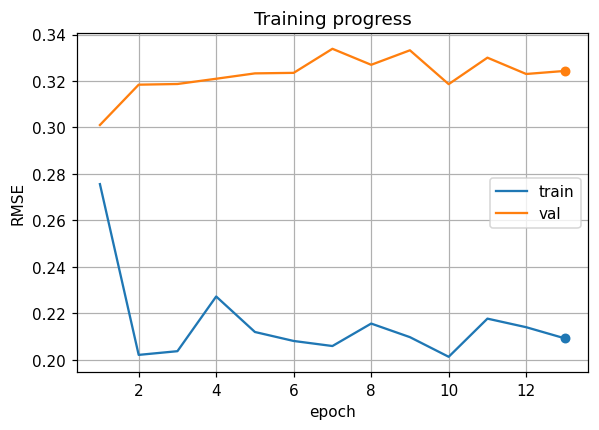

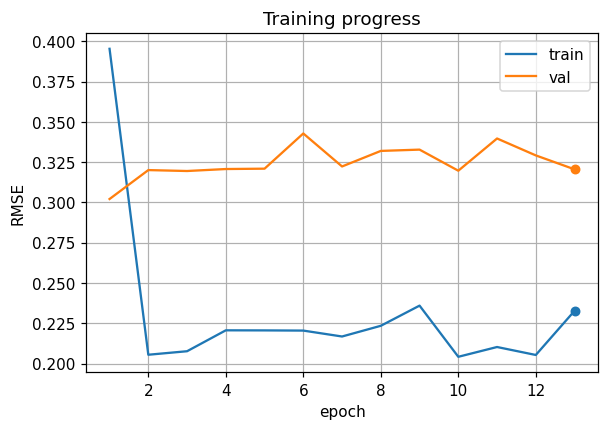

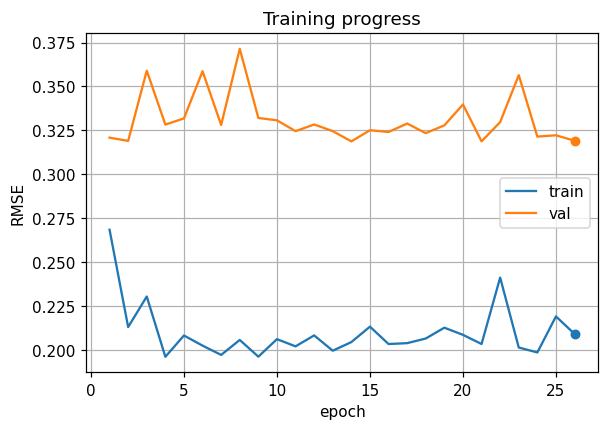

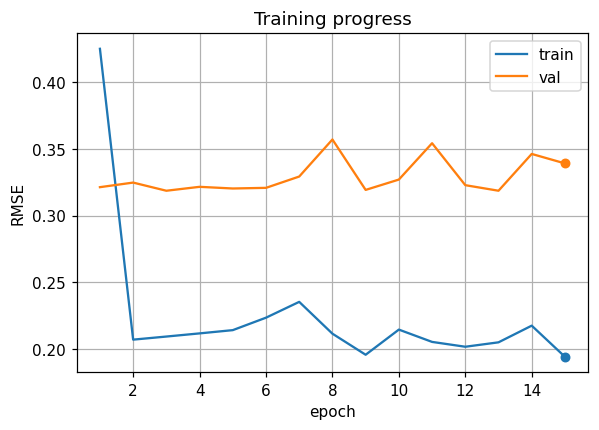

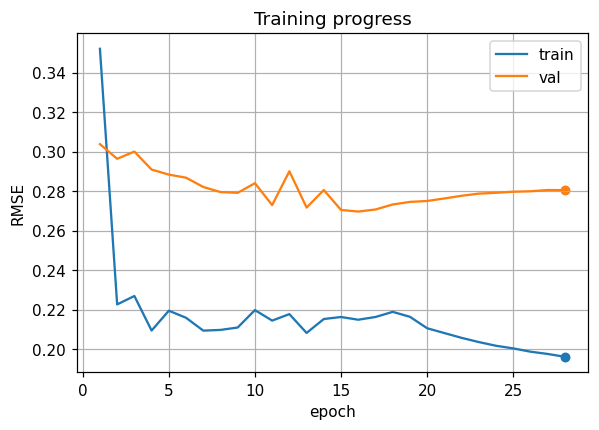

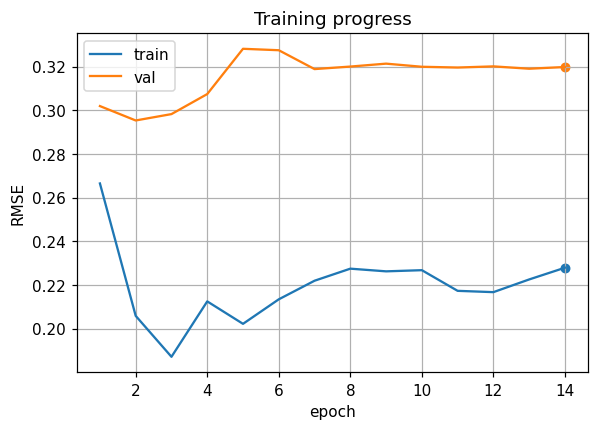

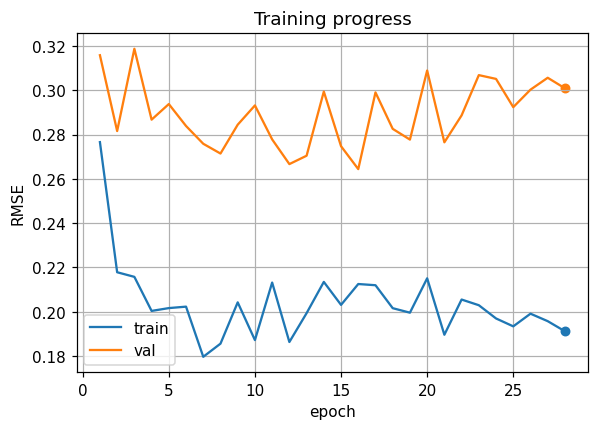

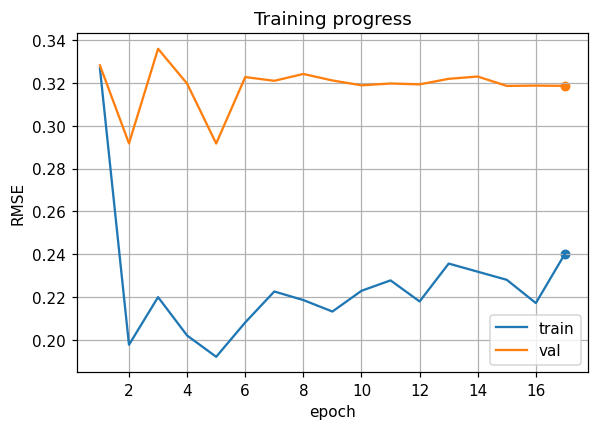

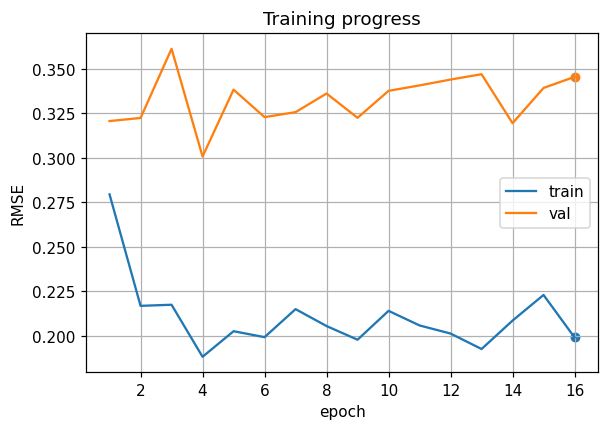

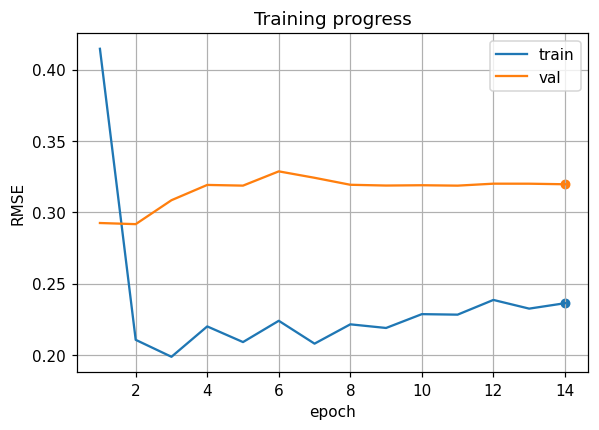

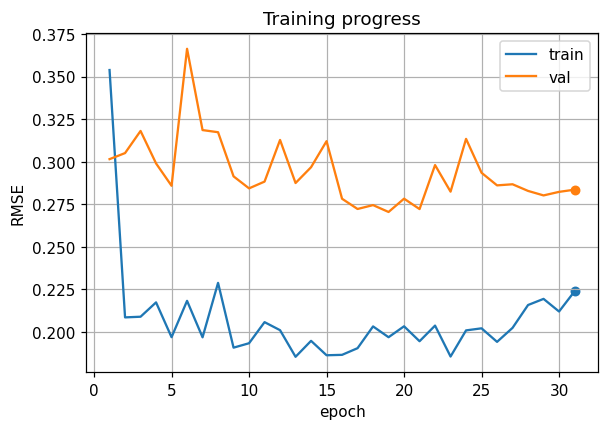

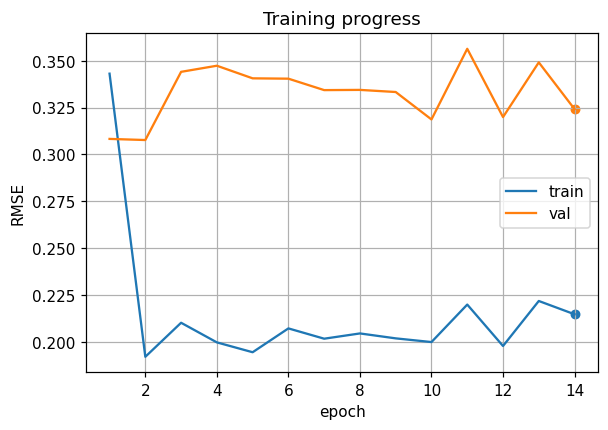

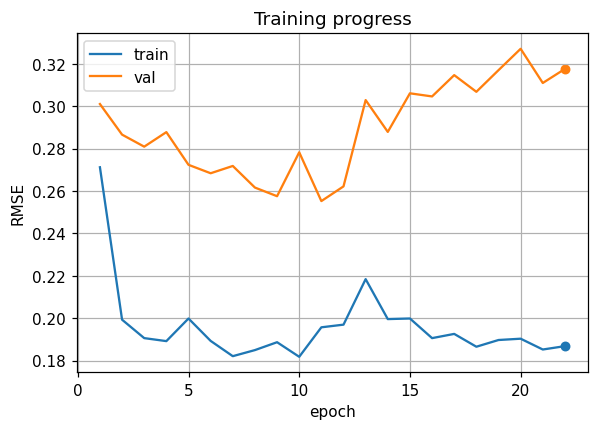

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

def cleanup_cb(study, trial):
    # Python‐side
    gc.collect()
    # CUDA‐side (no‐op on CPU only)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
study.optimize(
    objective_train,
    n_trials = 120,
    n_jobs   = 1,
    callbacks=[live_cb, cleanup_cb],
)

# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
